# Momentum (Optimization) - Dive into Deep Learning

## **Group 11:**

- Bùi Nguyễn Gia Huy - MSHV: 2570201
- Lê Ngọc Minh Thư - MSHV: 2570331
- Nguyễn Xuân Trường - MSHV: 2570526
- Phạm Kiều Nhật Anh - MSHV: 2580805
- Lê Công Minh - MSHV: 2212044

*Leader: Bùi Nguyễn Gia Huy - huybui.cse@hcmut.edu.vn*

Link to chapter D2L: https://d2l.ai/chapter_optimization/momentum.html


# Prerequisites

To ensure proper execution of this notebook, we **recommend** running this notebook in a **GPU-enabled runtime environment** (e.g. T4 from Colab), as our implementation employs Momentum optimization on the MNIST dataset, which benefits significantly from GPU acceleration.

# 1. Introduction

In optimization for deep learning, **Gradient Descent (GD)** and **Stochastic Gradient Descent (SGD)** are foundational algorithms for the model training process. However, their performance is often limited by the geometric structure of the loss function, especially in large models with a non-convex and **ill-conditioned** landscape. In such cases, the gradient step updates can oscillate strongly in some directions with high curvature while progressing very slowly in directions with small curvature.

Momentum was originally proposed by Polyak (the **Heavy-ball method** - 1964) in convex optimization, adding the concept of **"velocity,"** a moving average of previous gradients, to smooth the update direction and improve the convergence speed.  In the context of modern deep learning, this mechanism helps reduce oscillations in regions with high curvature, maintains inertia along stable descent directions, and often yields better empirical convergence results than plain SGD.

Momentum is widely used across many deep learning models, including CNNs, RNNs, and large-scale vision models.

* **Optimizing complex objective functions in Computer Vision and NLP:** Momentum helps image or language processing networks converge better when the loss surface contains many **"narrow valleys."**
* **Foundation for modern optimizers:** Adam, RMSProp, and Nadam all integrate the Momentum idea into their update formulas, proving that this concept plays a core constitutive role in modern optimization systems.
* **Training large-scale models:** In distributed or multi-GPU environments, Momentum reduces the necessity for meticulous learning rate tuning and helps models stabilize better with large batch sizes.
* **Training deep neural networks:** Most early CNN, RNN, and Transformer models used **SGD with Momentum** to achieve fast and stable convergence. **VGGNet** and **ResNet** also use SGD with Momentum to train on ImageNet, as it navigates saddle points more effectively than Adam in the later stages of training.

# 2. The Optimization Problem in Deep Learning

The core problem in training Deep Learning models is finding the set of parameters $\theta$ that minimizes the objective (loss) function $f(\theta)$:

$$\min_{\theta \in \mathbb{R}^d} f(\theta)$$

This function $f$, characteristic of deep neural networks, is a **non-convex** function with an extremely complex optimization **landscape**. Classical optimization algorithms, particularly **Gradient Descent (GD)** or **Stochastic Gradient Descent (SGD)**, exhibit critical weaknesses when confronted with these characteristics, which is precisely the motivation for the invention of **Momentum**.


## 2.1. Key Challenges for Plain Gradient Descent

### 1. Ill-Conditioning and High Condition Number ($\kappa$)

The poor performance of plain gradient descent stems from **ill-conditioning**: the loss surface exhibits dramatically different curvature in different directions.

Consider a simple quadratic function
$$f(x,y) = 0.01x^2 + 5y^2$$

The second derivatives (curvatures) are  
- The curvature in the x-direction is $\frac{\partial^2 f}{\partial x^2} = 0.02$ (relatively flat)
- The curvature in the y-direction is $\frac{\partial^2 f}{\partial y^2} = 10$ (much steeper)

These form the constant Hessian matrix  :
$$H = \begin{bmatrix} 0.02 & 0 \\ 0 & 10 \end{bmatrix}$$

Its eigenvalues $\lambda_1 = 0.02$ and $\lambda_2 = 10$ are exactly the curvatures along the principal axes.  
The **condition number** is  
$$\kappa = \frac{\lambda_{\max}}{\lambda_{\min}} = \frac{10}{0.02} = 500$$

### Physical intuition  
Imagine a ball placed on this surface:  
- Along the x-axis (curvature 0.02) it rolls very slowly → almost flat.  
- Along the y-axis (curvature 10) it accelerates rapidly → very steep.

This difference creates a classic dilemma for gradient descent:  
- A **small** learning rate keeps the optimizer stable in the steep y-direction, but convergence in the flat x-direction becomes excruciatingly slow.  
- A **large** learning rate speeds up progress in x, but causes violent oscillation or divergence in y.

The result is the well-known zig-zagging trajectory and extremely slow overall convergence.

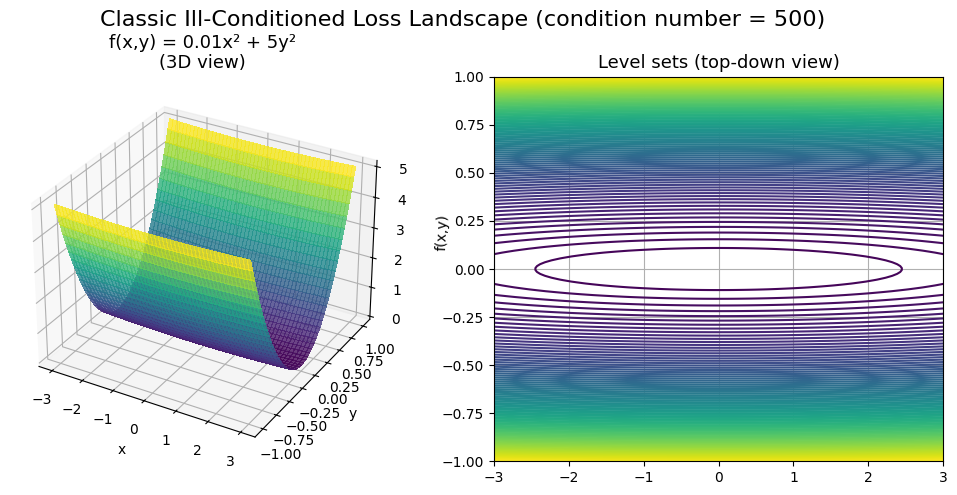

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(x, y):
    return 0.01*x**2 + 5*y**2

# Grid
x = np.linspace(-3, 3, 400)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure(figsize=(10, 5))

# 3D surface
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=False)
ax1.set_title('f(x,y) = 0.01x² + 5y²\n(3D view)', fontsize=13)
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('f(x,y)', labelpad=10)

# Contour plot with labels
ax2 = fig.add_subplot(122)
cp = ax2.contour(X, Y, Z, 100, cmap='viridis')
ax2.set_title('Level sets (top-down view)', fontsize=13)
ax2.grid(True)

plt.suptitle('Classic Ill-Conditioned Loss Landscape (condition number = 500)',
             fontsize=16)
plt.tight_layout()
plt.show()

## 2.2 The Geometry of Curvature
The second-order Taylor expansion tells us how the function changes for a small step $\Delta\mathbf{x}$ of fixed length $\|\Delta\mathbf{x}\|=1$:
$$
f(\mathbf{x} + \Delta\mathbf{x}) \approx f(\mathbf{x}) + \nabla f^\top \Delta\mathbf{x} + \frac{1}{2} \Delta\mathbf{x}^\top H \Delta\mathbf{x}.
$$
The term $\Delta\mathbf{x}^\top H \Delta\mathbf{x}$ is exactly the **curvature contribution**.

- Left: unit circle → all directions have identical curvature (isotropic case, $H = I$)
- Right: after linear transformation by $H$ → becomes a highly elongated ellipse  
  → the same unit-length step now changes the function value by a factor of up to 20x depending on direction.

Eigenvalues: [ 0.02 10.  ]
Condition number κ = 500.0


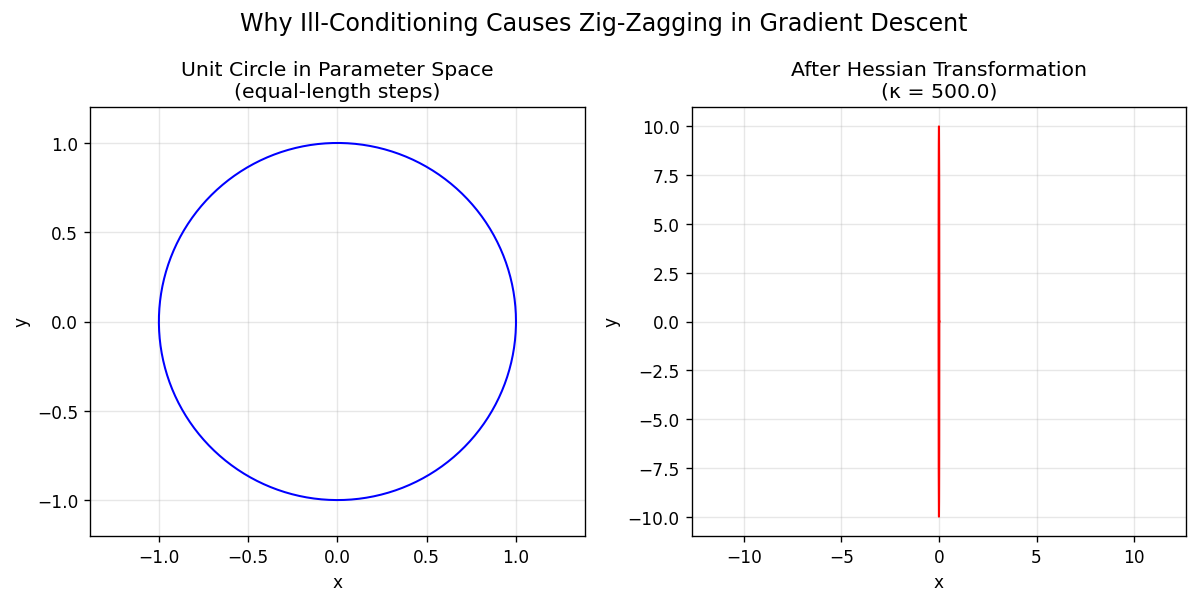

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

# Ill-conditioned quadratic: f(x,y) = 0.01x² + 5y²
H = np.array([[0.02, 0.0],
              [0.0, 10.0]])          # Constant Hessian

# Eigenvalues and condition number
eigvals = LA.eigvals(H)
print(f"Eigenvalues: {eigvals}")
print(f"Condition number κ = {eigvals.max()/eigvals.min():.1f}")

# Unit circle in parameter space
theta = np.linspace(0, 2*np.pi, 300)
unit_circle = np.column_stack((np.cos(theta), np.sin(theta)))

# Transform by the Hessian: Δf ≈ (1/2) Δxᵀ H Δx
transformed = (H @ unit_circle.T).T

# Plot
plt.figure(figsize=(10, 5), dpi=122)
plt.subplot(121)
plt.plot(unit_circle[:,0], unit_circle[:,1], 'b-', linewidth=1.2)
plt.title('Unit Circle in Parameter Space\n(equal-length steps)', fontsize=12)
plt.axis('equal'); plt.grid(alpha=0.3); plt.xlabel('x'); plt.ylabel('y')

plt.subplot(122)
plt.plot(transformed[:,0], transformed[:,1], 'r-', linewidth=1.2)
plt.title(f'After Hessian Transformation\n(κ = {eigvals.max()/eigvals.min():.1f})', fontsize=12)
plt.axis('equal'); plt.grid(alpha=0.3); plt.xlabel('x'); plt.ylabel('y')

plt.suptitle('Why Ill-Conditioning Causes Zig-Zagging in Gradient Descent',
             fontsize=14,  y=0.98)
plt.tight_layout()
plt.show()

## 2.3. Momentum's Solution

**Momentum** aims to mitigate these phenomena by using an exponentially decaying **moving average** of the gradient over time to smooth the update direction. This technique:

* **Damps Oscillation:** By accumulating previous updates, it reduces the detrimental effect of high curvature (ill-conditioning) and the resulting zig-zag path.
* **Maintains Inertia:** It allows the algorithm to maintain velocity (inertia) through flat regions or **saddle points**, helping to "push" past areas of small gradient.
* **Reduces Noise Sensitivity:** By averaging the gradients over several steps, it reduces the variance caused by the SGD's minibatch sampling, leading to a more stable and reliable descent path.

# 3. Mathematical Foundations

In gradient-based optimization, one challenge arises when the loss landscape is **ill-conditioned** - that is, when the curvature varies significantly across different directions. In such cases, standard gradient descent or stochastic gradient descent (SGD) can exhibit **zig-zagging** behavior, slowing convergence along shallow directions while oscillating across steep ones. Momentum is designed to address this issue.

First, let consider how the gradient is computed in minibatch stochastic gradient descent (SGD). At iteration $t$, the gradient estimate using a minibatch $\beta_t$ is given by:

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\beta_t|} \sum_{i \in \beta_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\beta_t|} \sum_{i \in \beta_t} \mathbf{h}_{i, t-1};
$$
$$\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$$

where $\mathbf{h}_{i, t-1} $ is the stochastic gradient descent for sample $i$ using the weights updated at time $t-1$.

Momentum modifies the update by accumulating a running average of past gradients, rather than relying solely on the current gradient. This leads to faster convergence, especially in shallow directions, by smoothing updates and reducing zig-zagging in steep directions.

$$\begin{split}\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}\end{split}$$

This motivating example sets the stage for the formal **Momentum Update Rule** and its interpretation as **an exponentially weighted (leaky) average** of past gradients

## 3.1 Momentum Update Rule

### 3.1.1 Standard Momentum Formulation
Momentum replaces the raw instantaneous gradient with a velocity vector that accumulates information from past gradients. Instead of updating parameters using only $\nabla f(x_t)$, momentum smooths the gradient direction over time, allowing the optimization process to accelerate along consistent descent directions while reducing oscillations in directions with noisy or high-curvature gradients.

The standard formulation used in deep learning (Sutskever et al., 2013) is:

$$
\begin{aligned}
\mathbf{v}_{t+1} &= \beta \mathbf{v}_t + \eta \nabla f(\mathbf{x}_t) \\
\mathbf{x}_{t+1} &= \mathbf{x}_t - \mathbf{v}_{t+1}
\end{aligned}
$$

Where:
- $\beta \in [0,1)$ is the momentum coefficient (common values: 0.9 or 0.99)
- $\eta$ is the learning rate
- $v_0 = 0$

The velocity term $v_t$ acts as a smoothed accumulation of past gradients, which will be analyzed as an exponentially weighted moving average.

In this formulation, the gradient is first scaled by $\eta$, added into the velocity, and the updated velocity is then used to move the parameters.


*Note: While theoretical papers often absorb $\eta$ into the velocity update, PyTorch applies $\eta$ during the parameter update step. In this coursework, we adhere to the PyTorch convention in our implementation sections. More information, please refer to this URL: https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html*

### 3.1.2 Scaled-Gradient Formulation (Used in Some Visualizations)
An equivalent form is:
$$\begin{aligned}
\mathbf{v}_{t+1} &= \beta \mathbf{v}_t - \eta \nabla f(\mathbf{x}_t) \\
\mathbf{x}_{t+1} &= \mathbf{x}_t + \mathbf{v}_{t+1}
\end{aligned}
$$

Both forms are mathematically identical - the sign convention differs depending on whether the minus sign is applied inside the velocity update or during the parameter update.

### 3.1.3 Alternative Sign-Convention Formulation
Some references absorb the learning rate into the parameter update step instead of the velocity update, yielding the following equivalent form:
$$
\begin{aligned}
\mathbf{v}_{t+1} &= \beta \mathbf{v}_t - \nabla f(\mathbf{x}_t) \\
\mathbf{x}_{t+1} &= \mathbf{x}_t + \eta \mathbf{v}_{t+1}
\end{aligned}
$$
Here, the minus sign appears inside the velocity update, while the parameter step explicitly multiplies the velocity by $\eta$.

Equations (1)-(3) differ only by algebraic rearrangement and sign placement; all describe the same underlying dynamical system. The choice of convention is typically determined by:
- Software implementation style (update inside velocity vs. update inside parameters),
- Visualization preference (explicit negative-gradient direction),
- otational convenience.

Regardless of the form, momentum transforms the update rule from a purely local gradient step to a smoothed, aggregated direction that incorporates historical gradient information. This lays the foundation for viewing momentum as an **exponentially weighted (leaky) average**.

### 3.1.4 Why Introducing Momentum Helps
Momentum provides two major benefits during optimization:

**(1) Damping Oscillations (Reduction of Zig-Zagging)**

In directions where gradients oscillate (e.g., narrow valleys with steep walls), vanilla SGD updates alternate signs, producing zig-zag motion.
Since $v_t$ averages gradients across iterations, it smooths noise and reduces these oscillations, allowing the trajectory to stabilize.

**(2) Accelerating Motion Along Consistent Directions**

In directions where gradients maintain similar orientation across steps, the velocity accumulates.
Under approximately constant gradients,
$$v_{t+1} \approx \frac{\eta}{1 - \beta} \nabla f(\mathbf{x}_t)$$
which increases the *effective* learning rate from $\eta$ to $\eta/(1 - \beta)$.

## 3.2 Momentum as an Exponentially Weighted (Leaky) Average

### 3.2.1 Expanded Sum epresentation
Momentum does not use the current gradient alone.
Instead, the velocity vector stores an exponentially weighted moving average (EWMA) of all past gradients.

Starting from the update equation:
$$v_{t+1} = \beta v_t + \eta \nabla f(x_t)$$

We can expand the recurrence:
\begin{align}
v_{t+1}
&= \beta \left( \beta v_{t-1} + \eta \nabla f(x_{t-1}) \right) + \eta \nabla f(x_t) \\
&= \eta \Bigl( \nabla f(x_t) + \beta \nabla f(x_{t-1}) + \beta^2 \nabla f(x_{t-2}) + \cdots \Bigr)
\end{align}

Thus, in closed form:
$$\mathbf{v}_{t+1} = \eta \sum_{k=0}^{t} \beta^k \nabla f(\mathbf{x}_{t-k})$$

This shows that:
- Gradients from recent steps have large weight
- Gradients from older steps decay exponentially as $\beta^k$
- Momentum is literally a leaky average of past gradients


### 3.2.2 Effective Memory Length
Although momentum aggregates all past gradients, their contributions decay geometrically.
Given the expanded sum representation,
$$\mathbf{v}_{t+1} = \eta \sum_{k=0}^{t} \beta^k \nabla f(\mathbf{x}_{t-k})$$
the gradient computed $k$ iterations earlier is weighted by
.
This decay structure allows us to characterize how far back momentum “effectively” remembers past information.

**(1) Total mass of the geometric weights**

The unnormalized weights form a geometric series:
$$ S_\infty =\sum_{k=0}^{\infty}\beta^k = \frac{1}{1 - \beta} $$
This quantity serves as a convenient proxy for the number of past steps whose influence is non-negligible.
Thus, momentum is often said to have an effective memory length
$$\text{Effective memory} \approx \frac{1}{1 - \beta} $$
For example, $\beta = 0.9$ corresponds to roughly 10 effective steps, whereas $\beta = 0.$ corresponds to roughly 100.

**(2) Fraction of total weight captured by the most recent K steps**

A more precise view examines how much cumulative weight lies within the window $\{0,…,K\}$.
The cumulative mass is:
$$ S_K = \sum_{k=0}^{K}\beta^k = \frac{1 - \beta^{k+1}}{1 - \beta} $$
After normalizing by the total mass $1/(1 - \beta)$, the fraction of influence captured by the most recent $K$ steps becomes:
$$ \text{fraction} = \frac{S_K}{S_\infty} = 1 - \beta^{k+1}$$

If we wish to know how many steps $K$ are needed to retain a proportion $p$ (e.g., $p= 0.9$ or $0.95$) of the total effective weight, we solve:
$$
1 - \beta^{K+1} \ge p
\;\Longleftrightarrow\;
\beta^{K+1} \le 1 - p.
$$
Taking logarithms yields:
$$ K \ge \frac{\ln(1 - p)}{\ln(\beta)} - 1.$$
This formula makes explicit how slowly the contributions decay when $\beta$ is close to 1. For instance, with $\beta = 0.9$ around 22 steps are required to accumulate 90% of the total weight, whereas with $\beta = 0.$, roughly 228 steps are needed.

### 3.2.3 Smoothing Effect

Because $v_t$ is an average over past gradients:
- High-frequency oscillations (e.g., gradients that rapidly change sign) tend to cancel out. **$\rightarrow$ Momentum reduces zig-zagging in narrow valleys.**

- When gradients point consistently in the same direction across iterations, their contributions accumulate. **$\rightarrow$ Momentum amplifies motion along stable descent directions, enabling faster progress.**

This explains why momentum produces smoother and more efficient optimization trajectories than vanilla SGD.

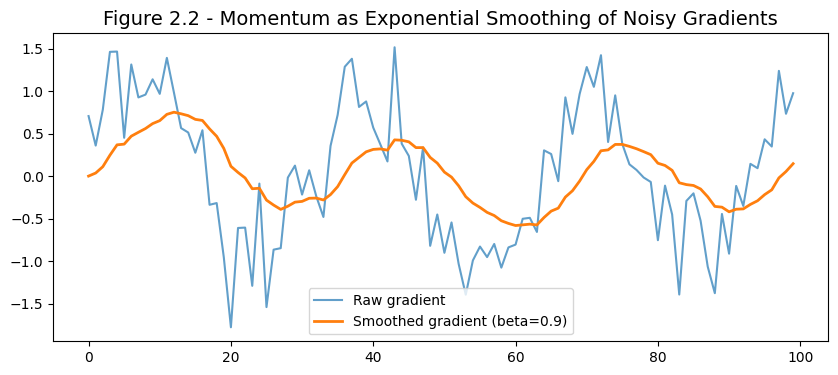

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Synthetic noisy gradient signal
np.random.seed(0)
t = np.arange(100)
grad = np.sin(t * 0.2) + 0.4 * np.random.randn(100)

# Apply EMA (same equation as momentum without η)
beta = 0.9
v = np.zeros_like(grad)
for i in range(1, len(grad)):
    v[i] = beta * v[i-1] + (1 - beta) * grad[i]   # normalized EMA

plt.figure(figsize=(10, 4))
plt.plot(grad, label="Raw gradient", alpha=0.7)
plt.plot(v, label=f"Smoothed gradient (beta={beta})", linewidth=2)
plt.title("Figure 2.2 - Momentum as Exponential Smoothing of Noisy Gradients", fontsize=14)
plt.legend()
plt.show()


### 3.2.4 Intuitive View of Exponential Decay
For each past gradient:

$$ \text{Weight at lag 𝑘} = \beta^k $$

Thus:
- **Exponential decay**: the weight decreases geometrically as $k$ increases.
- **Distant gradients still matter**, but their influence becomes progressively smaller.
- **The decay rate is entirely determined by** $\beta$ - larger $\beta$ values cause slower decay, meaning momentum retains longer memory.

## 3.3 How β Controls Smoothing
To understand the how different choices of $\beta$ (momentum or exponential decay factor) help to smooth the gradient descent, look at the chart below.

Note before reading the chart:
- Each curve in the chart below represents a different value of $\beta$
- The x-axis showing discrete time steps from 0 to 50 and the y-axis showing the relative weight of a gradient $k$ steps in the past during momentum-based gradient descent.

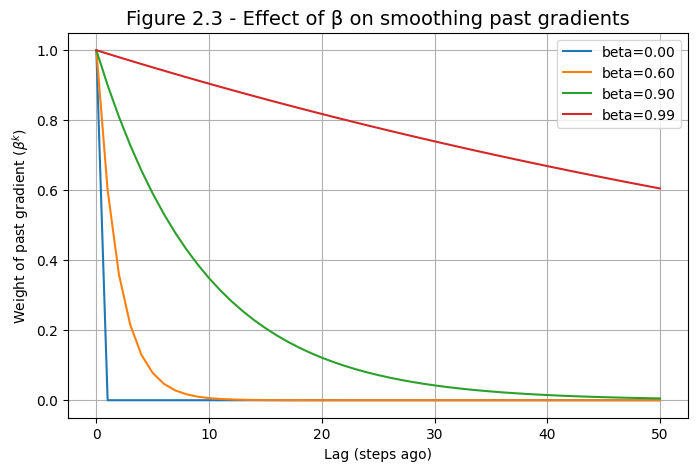

In [ ]:
import torch
import matplotlib.pyplot as plt

betas = [0.0, 0.6, 0.9, 0.99]
x = torch.arange(51).numpy()

plt.figure(figsize=(8,5))
for beta in betas:
    plt.plot(x, beta**x, label=f'beta={beta:.2f}')
plt.xlabel("Lag (steps ago)")
plt.ylabel("Weight of past gradient ($β^k$)")
plt.title("Figure 2.3 - Effect of β on smoothing past gradients", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


## 3.4 Why Momentum Accelerates Convergence
Adding this smoothed velocity to the parameter update:
$$\mathbf{x}_t = \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t$$

Recall the expanded form of the momentum velocity:
$$\mathbf{v}_{t} = \eta \sum_{\tau=0}^{t-1} \beta^\tau \nabla f(\mathbf{x}_{t-1-\tau})$$
where $\beta \in [0,1)$ is the momentum coefficient. This expression shows that
$v_t$ is a weighted sum of past gradients, with more recent gradients carrying higher weight and older gradients decaying geometrically.

When the gradients remain approximately constant across iterations, i.e., $\nabla f(\mathbf{x}_{t-1-\tau}) \approx g$, the velocity simplifies to
results in an effective step size that can exceed the raw learning rate $\eta$
in directions where gradients are consistent, allowing faster convergence along shallow valleys.
$$ v_t \approx \sum_{\tau=0}^{t-1} \beta^\tau \approx \frac{1}{1- \beta} \text{(for large t)}  $$
by the geometric series formula. Multiplying by the learning rate $\eta$ in the update gives an **effective step size** of
$$\eta_{eff} \approx \frac{\eta}{1-\beta}$$

Compared to standard gradient descent, this shows that momentum amplifies the step size in directions where gradients are consistent, allowing faster progress through shallow valleys while simultaneously reducing oscillations along steep or zig-zagging directions. As $\beta$ approaches 1, the effective step can become significantly larger than the original learning rate $\eta$, enabling more rapid convergence in smooth regions of the loss landscape.

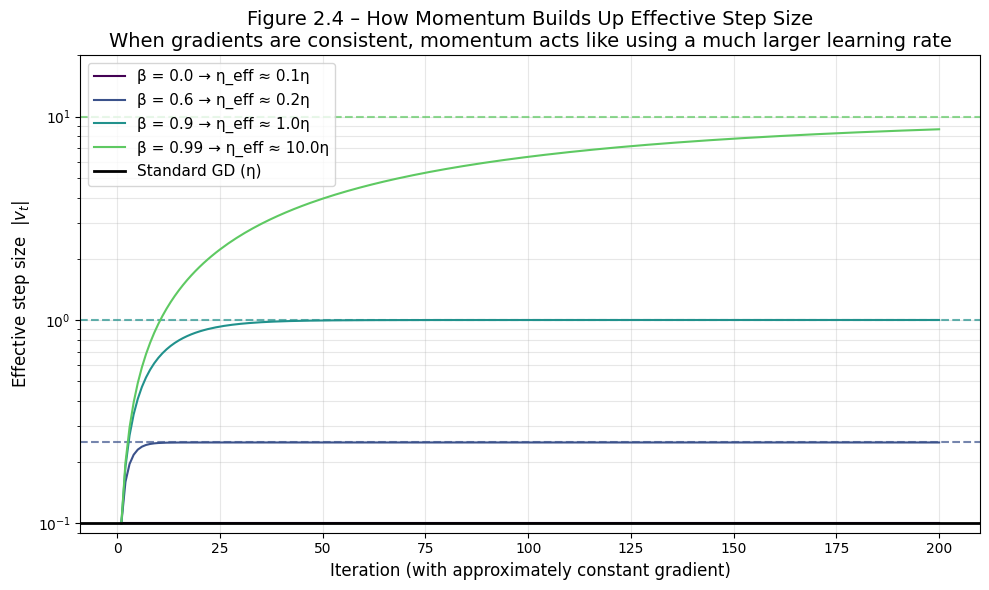

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Mô phỏng gradient không đổi (g = 1.0) – giống như trong thung lũng thoải
g_constant = 1.0
eta = 0.1
steps = 200
beta_values = [0.0, 0.6, 0.9, 0.99]

plt.figure(figsize=(10, 6))

for i, beta in enumerate(beta_values):
    v = 0.0
    velocity_history = []

    for t in range(steps):
        v = beta * v + eta * g_constant          # Cập nhật vận tốc (leaky average)
        velocity_history.append(v)

    color = plt.cm.viridis(i / len(beta_values))  # màu đẹp dần
    plt.plot(range(1, steps+1), velocity_history,
             label=f'β = {beta} → η_eff ≈ {eta/(1-beta):.1f}η',
             linewidth=1.5, color=color)

    if beta > 0:
        plt.axhline(y=eta/(1-beta), color=color, linestyle='--', alpha=0.7,
                    linewidth=1.5)

# Đường chuẩn GD
plt.axhline(y=eta, color='black', linestyle='-', linewidth=2, label='Standard GD (η)')

plt.yscale('log')
plt.ylim(0.09, 20)
plt.xlabel('Iteration (with approximately constant gradient)', fontsize=12)
plt.ylabel('Effective step size  |$v_t$|', fontsize=12)
plt.title('Figure 2.4 – How Momentum Builds Up Effective Step Size\n'
          'When gradients are consistent, momentum acts like using a much larger learning rate',
          fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

This figures simulates this process with a constant gradient $g = 1.0$. The solid curves show the actual velocity magnitude over time, while dashed lines mark the theoretical limit $\eta/(1-\beta)$.

With $\beta = 0.9$ (the most common choice), momentum eventually behaves as if using a learning rate **10x larger** than nominal $\eta$ — explaining the dramatic acceleration along the flat direction observed in Figure 1.3. Higher $\beta$ values (0.95-0.99) yield even stronger amplification (20-100x), which is why such settings are frequently used in RNNs and large language models.

# 4. Theoretical analysis: Why Momentum works on Convex Quadratics

We now prove rigorously that, on any convex quadratic loss — the mathematical foundation of least-squares, logistic regression warm-start, and many neural network initialisation regimes — both gradient descent and momentum **decompose into independent scalar optimisations along the eigenvector directions of the Hessian**.

## 4.1 The Loss is a Convex Quadratic
Consider the standard supervised learning setting:
- Data matrix $ X \in \mathbb{R}^{n \times m} $ (full column rank), targets $ y \in \mathbb{R}^n $
- Parameters $ \theta \in \mathbb{R}^m $

The squared error loss is
$$\mathcal{L}(\theta) = \|X\theta - y\|^2 = (X\theta - y)^\top (X\theta - y)$$
Expanding:
$$\mathcal{L}(\theta) = \theta^\top X^\top X \theta - 2\theta^\top X^\top y + y^\top y$$
Define
$$Q = 2X^\top X, \quad \mathbf{c} = -2X^\top y, \quad b = y^\top y$$
Then
$$
\boxed{\mathcal{L}(\theta) = \frac{1}{2} \theta^\top Q \theta + \theta^\top \mathbf{c} + b}.
$$

**Why is $ Q \succ 0 $ (positive definite)?**  
- $ Q $ is symmetric by construction.  
- For any $ \theta \neq 0 $:
  $$\theta^\top Q \theta = 2\|X\theta\|^2 > 0 \quad \text{(because X has full column rank)}$$
→ $ Q $ is symmetric positive definite (SPD) → $ \mathcal{L} $ is strongly convex → unique global minimum.

## 4.2 Shift coordinates to the minimum (eliminate the linear term)
Consider the function:

$$\mathcal{L}(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b. $$

The minimizer satisfies $\nabla \mathcal{L}(x) = 0 $:
$$
Q\mathbf{x}^* + \mathbf{c} = 0 \quad \Rightarrow \quad
\boxed{\mathbf{x}^* = -Q^{-1}\mathbf{c}}.
$$
Define the deviation variable
$$
\mathbf{v} = \mathbf{x} - \mathbf{x}^* \quad \Rightarrow \quad \mathbf{x} = \mathbf{x}^* + \mathbf{v}.
$$
Substituting $\mathbf{\mathbf{x}} = \mathbf{x}^* + \mathbf{v}$ into the quadric loss function, we have:
$$\mathcal{L}(\mathbf{x}^* + \mathbf{v}) = \frac{1}{2}(\mathbf{x}^* + \mathbf{v})^\top \mathbf{Q}(\mathbf{x}^* + \mathbf{v}) + (\mathbf{x}^* + \mathbf{v})^\top\mathbf{c} + b $$
Expand:
\begin{align} \mathcal{L}(\mathbf{x}^* + \mathbf{v}) &= \frac{1}{2} [(\mathbf{\mathbf{x}}^*)^\top Q\mathbf{x}^* + 2(\mathbf{\mathbf{x}}^*)^\top Q\mathbf{v} + \mathbf{v}^\top Q\mathbf{v}] + (\mathbf{\mathbf{x}}^*)^\top\mathbf{c} + \mathbf{v}^\top\mathbf{c} + b \\
&= \frac{1}{2}(\mathbf{x}^*)^\top Q\mathbf{x}^* + (\mathbf{x}^*)^\top Q\mathbf{v} + \frac{1}{2}\mathbf{v}^\top Q\mathbf{v} + (\mathbf{x}^*)^\top\mathbf{c} + \mathbf{v}^\top\mathbf{c} + b\\
&= \underbrace{(\mathbf{x}^*)^\top Q\mathbf{v} + \mathbf{v}^\top\mathbf{c}}_{\text{linear in v}}
+ \underbrace{\frac{1}{2}(\mathbf{x}^*)^\top Q\mathbf{x}^* + (\mathbf{x}^*)^\top\mathbf{c} + b}_{\text{constant}}
+ \underbrace{\frac{1}{2}\mathbf{v}^\top Q\mathbf{v}}_{\text{quadratic in v}}
\end{align}

By the linear term, we have:
$$(\mathbf{x}^*)^\top Q\mathbf{v} + \mathbf{v}^\top\mathbf{c} = (\mathbf{x}^*)^\top Q\mathbf{v} + \mathbf{v}^\top(-Q\mathbf{x}^*)$$

Using the transpose property of a matrix product $(\mathbf{v}^{\top }Q\mathbf{x}^{*})^{\top }=(\mathbf{x}^{*})^{\top }Q^{\top }\mathbf{v}$), we have:
$$\mathbf{v}^{\top }Q\mathbf{x}^{*}=(\mathbf{x}^{*})^{\top }Q^{\top }\mathbf{v}=(\mathbf{x}^{*})^{\top }Q\mathbf{v}$$

Substituting this back into the original expression:
$$(\mathbf{x}^{*})^{\top }Q\mathbf{v}-(\mathbf{x}^{*})^{\top }Q\mathbf{v} = 0$$

Simplifying the formula, we have:
$$
\mathcal{L}(\mathbf{x}^* + \mathbf{v}) = \frac{1}{2} \mathbf{v}^\top Q \mathbf{v} + \mathcal{L}(\mathbf{x}^*).
$$
Thus, **without loss of generality**, we study the pure quadratic
$$
\boxed{h(\mathbf{v}) = \frac{1}{2} \mathbf{v}^\top Q \mathbf{v}}.
$$

## 4.3 Eigen-Decomposition and Decoupling
Since $\mathbf{Q}$ is real symmetric and positive definite, it has the spectral decomposition
$$
\mathbf{Q} = \mathbf{O}^\top \Lambda \mathbf{O}, \quad \mathbf{O}^\top \mathbf{O} = I, \quad
\Lambda = \operatorname{diag}(\lambda_1, \lambda_2, \dots, \lambda_m),\ \lambda_i > 0.
$$
where:
- $\mathbf{O}$ is an orthogonal matrix of eigenvectors ($ \mathbf{O}^\top \mathbf{O}= I$)
- $\Lambda$ is a diagonal matrix of eigenvalues ($\lambda_i > 0$), which correspond to the curvature along each principal direction.

By defining a new variable $\mathbf{z} = O \mathbf{v}$, we rotate the coordinate system so that the axes align with the eigenvectors of
$Q$. In this rotated basis:
$$
\boxed{\mathbf{v} = O^\top \mathbf{z}}.
$$
Then the quadratic can be rewritten as:
\begin{align}
h(\mathbf{x}) &= \frac{1}{2} \mathbf{v}^\top \mathbf{Q} \mathbf{v} + h(\mathbf{x}^*) \\
&=  \frac{1}{2} (\mathbf{O}^\top \mathbf{z})^\top \mathbf{Q} (\mathbf{O}^\top \mathbf{z})+ h(\mathbf{x}^*) \\
&=  \frac{1}{2}\mathbf{z}^\top \mathbf{O} \mathbf{Q}\mathbf{O}^\top\mathbf{z} + h(\mathbf{x}^*)\\
&= \frac{1}{2}\mathbf{z}^\top\mathbf{O}\mathbf{O}^\top \Lambda \mathbf{O}\mathbf{O}^\top\mathbf{z} + h(\mathbf{x}^*)\\
&=  \frac{1}{2}\mathbf{z}^\top  \Lambda \mathbf{z} + b^*\\
\end{align}
where $b^* = h(\mathbf{x}^*)$

Continue to transform $h(\mathbf{x})$, we have:
\begin{align}
\mathbf{z} =
\begin{bmatrix} z_1 \\ z_2 \\ \vdots \\ z_m \end{bmatrix}, \quad &
\Lambda =
\begin{bmatrix}
\lambda_1 & 0 & \dots & 0 \\
0 & \lambda_2 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \lambda_m
\end{bmatrix}.\end{align}

Then,
\begin{align}
\mathbf{z}^\top  \Lambda \mathbf{z} &= \begin{bmatrix} z_1, z_2, ..., z_m\end{bmatrix}\begin{bmatrix}
\lambda_1 & 0 & \dots & 0 \\
0 & \lambda_2 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \lambda_m
\end{bmatrix}\begin{bmatrix} z_1 \\ z_2 \\ \vdots \\ z_m \end{bmatrix}\\
&= \begin{bmatrix} z_1, z_2, ..., z_m\end{bmatrix}\begin{bmatrix}
\lambda_1 z_1 \\
\lambda_2 z_2 \\
\vdots \\
\lambda_m z_m
\end{bmatrix}\\
&= \sum_{i=1}^m \lambda_i z_i^2
\end{align}

The quadratic function becomes fully decoupled, $h(\mathbf{x}) = \frac{1}{2}\sum_{i=1}^m \lambda_i z_i^2$

This means that each component $z_i$ corresponds to an independent scalar quadratic with curvature $\lambda_i$. In other words, the original m-dimensional coupled problem is now separated into m independent one-dimensional quadratics, one along each eigenvector of $\mathbf{Q}$.

**Consequence for optimization dynamics**  
Because the gradient in the z-basis is exactly diagonal ( $\nabla h(z) = \Lambda z$), any gradient-based update that is linear in the gradient (plain GD, momentum, Adam, etc.) automatically decouples into m independent scalar recursions - each governed solely by its own eigenvalue $\lambda_i$. This is the precise mathematical reason why momentum can accelerate fast directions while simultaneously damping oscillations in slow directions, without the dimensions ever interfering with one another.

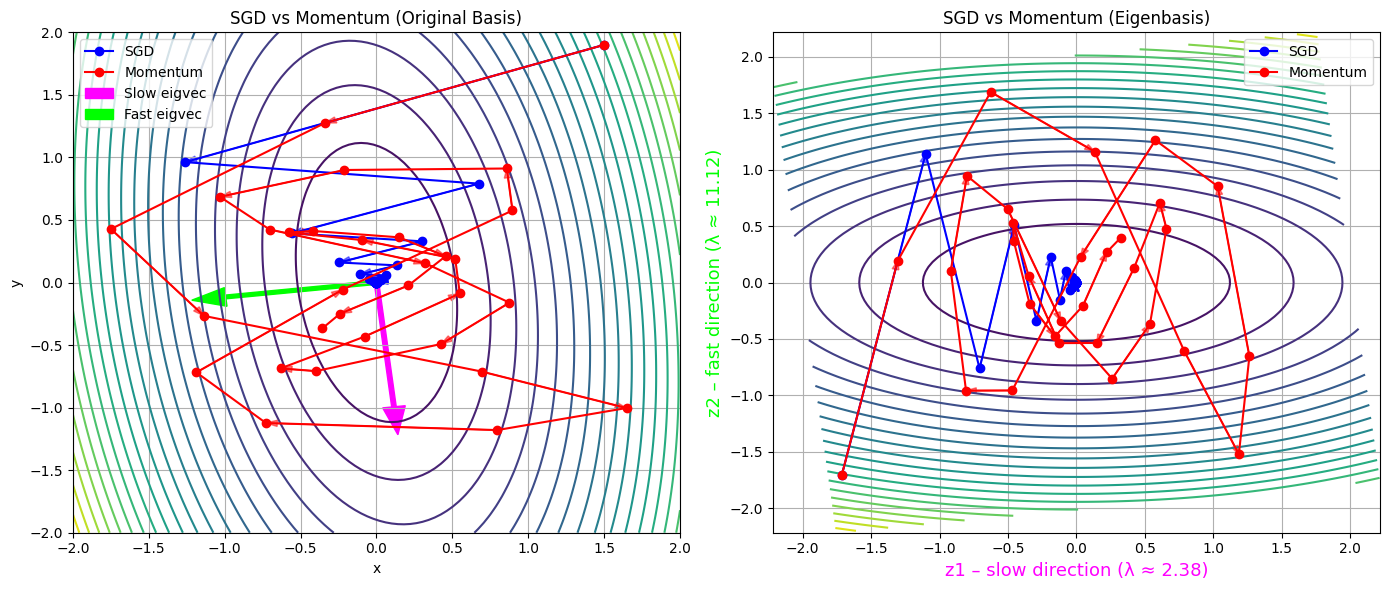

Eigenvalues: [ 2.3839377 11.1160623]
Slow direction (horizontal): λ = 2.3839377008567553
Fast direction (vertical):  λ = 11.116062299143245


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Define quadratic loss
# -----------------------
Q = np.array([[11, 1],
              [1, 2.5]])
eigvals, eigvecs = np.linalg.eigh(Q)

def grad(x):
    return Q @ x

def sgd_step(x, lr=0.15):
    return x - lr * grad(x)

def momentum_step(x, v, lr=0.1, beta=0.9):
    g = grad(x)
    v = beta * v + g
    x_new = x - lr * v
    return x_new, v

# -----------------------
# Initialize trajectories
# -----------------------
steps = 30
x0 = np.array([1.5, 1.9])

sgd_path = [x0.copy()]
mom_path = [x0.copy()]

x_sgd = x0.copy()
x_mom = x0.copy()
v = np.zeros_like(x0)

for _ in range(steps):
    x_sgd = sgd_step(x_sgd)
    sgd_path.append(x_sgd.copy())

    x_mom, v = momentum_step(x_mom, v, lr=0.1, beta=0.9)
    mom_path.append(x_mom.copy())

sgd_path = np.array(sgd_path)
mom_path = np.array(mom_path)

# -----------------------
# Original grid for contours
# -----------------------
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
V = np.stack([X, Y], axis=-1)
Z = np.einsum('ij,...j->...i', Q, V)
loss = 0.5 * np.einsum('...i,...i->...', V, Z)

# Rotate grid for eigenbasis
V_rot = V @ eigvecs
X_rot, Y_rot = V_rot[...,0], V_rot[...,1]
loss_rot = 0.5 * (eigvals[0]*X_rot**2 + eigvals[1]*Y_rot**2)

# -----------------------
# Plot side by side
# -----------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Original basis
axes[0].contour(X, Y, loss, levels=20)
axes[0].plot(sgd_path[:,0], sgd_path[:,1],'o-', color='blue', label='SGD')
axes[0].plot(mom_path[:,0], mom_path[:,1],'o-', color='red', label='Momentum')
for i in range(1, len(sgd_path), 2):
    axes[0].arrow(sgd_path[i-1,0], sgd_path[i-1,1],
                  sgd_path[i,0]-sgd_path[i-1,0], sgd_path[i,1]-sgd_path[i-1,1],
                  color='blue', alpha=0.5, head_width=0.05, length_includes_head=True)
    axes[0].arrow(mom_path[i-1,0], mom_path[i-1,1],
                  mom_path[i,0]-mom_path[i-1,0], mom_path[i,1]-mom_path[i-1,1],
                  color='red', alpha=0.5, head_width=0.05, length_includes_head=True)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('SGD vs Momentum (Original Basis)')
axes[0].grid(True)
axes[0].legend()

scale = 1.0
# slow eigenvector = eigvecs[:,0], fast = eigvecs[:,1]
axes[0].arrow(0, 0, scale*eigvecs[0,0], scale*eigvecs[1,0],
              color='magenta', width=0.03, head_width=0.15, label='Slow eigvec')
axes[0].arrow(0, 0, scale*eigvecs[0,1], scale*eigvecs[1,1],
              color='lime', width=0.03, head_width=0.15, label='Fast eigvec')
axes[0].legend()
# Eigenbasis
sgd_path_rot = sgd_path @ eigvecs
mom_path_rot = mom_path @ eigvecs
axes[1].contour(X_rot, Y_rot, loss_rot, levels=20)
axes[1].plot(sgd_path_rot[:,0], sgd_path_rot[:,1], 'o-',color='blue', label='SGD')
axes[1].plot(mom_path_rot[:,0], mom_path_rot[:,1], 'o-',color='red', label='Momentum')
for i in range(1, len(sgd_path_rot), 2):
    axes[1].arrow(sgd_path_rot[i-1,0], sgd_path_rot[i-1,1],
                  sgd_path_rot[i,0]-sgd_path_rot[i-1,0], sgd_path_rot[i,1]-sgd_path_rot[i-1,1],
                  color='blue', alpha=0.5, head_width=0.05, length_includes_head=True)
    axes[1].arrow(mom_path_rot[i-1,0], mom_path_rot[i-1,1],
                  mom_path_rot[i,0]-mom_path_rot[i-1,0], mom_path_rot[i,1]-mom_path_rot[i-1,1],
                  color='red', alpha=0.5, head_width=0.05, length_includes_head=True)
# Thêm vào cuối phần vẽ axes[1]
# Thay label của bạn bằng cái này
axes[1].set_xlabel(f'z1 – slow direction (λ ≈ {eigvals[0]:.2f})', fontsize=13, color='magenta')
axes[1].set_ylabel(f'z2 – fast direction (λ ≈ {eigvals[1]:.2f})', fontsize=13, color='lime')

axes[1].set_title('SGD vs Momentum (Eigenbasis)')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()

plt.show()
print("Eigenvalues:", eigvals)
print("Slow direction (horizontal): λ =", eigvals[0])
print("Fast direction (vertical):  λ =", eigvals[1])

We consider the quadratic function $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top Q \mathbf{x}$ with
$$Q = \begin{bmatrix} 11 & 1 \\ 1 & 2.5 \end{bmatrix}$$
This matrix is strongly ill-conditioned: its eigenvalues are approximately $\lambda_1 \approx 11.12$ and $\lambda_2 \approx 2.38$ (condition number $\kappa \approx 4.67$), and the off-diagonal term induces a rotation of the level sets by roughly $9^\circ$.

**Left panel (original basis)**: Level sets are tilted ellipses. SGD (blue) zig-zags strongly along the narrow valley, showing large oscillations near the minimum.

**Right panel (eigenbasis, $\mathbf{z} = O^\top \mathbf{x}$)**:
To fully decouple the quadratic, the two eigenvectors must rotate $\approx 98.5^\circ$  from the original axes. In this basis, the function becomes
$$f(z) =\frac{1}{2}\lambda_1 {z_1}^2 + \frac{1}{2}\lambda_2 {z_2}^2$$
completely eliminating coupling.

SGD oscillations are confined to the slow eigenvector direction, while convergence along the fast direction is rapid. Momentum ($\beta = 0.9$) further damps oscillations in both directions, descending quickly along the fast eigenvector and smoothly along the slow one.

This demonstrates that eigen-decomposition, even with a large rotation ($\approx 98.5^\circ$), transforms the 2D coupled problem into two independent scalar quadratics, making the differences between SGD and momentum visually and geometrically clear.

## 4.4 Dynamics of Gradient Descent and Momentum in the Eigenbasis (Perfect Decoupling)
After the change of variables $\mathbf{z} = O^\top \mathbf{x}$, the quadratic becomes
$$h(\mathbf{z}) = \tfrac12 \mathbf{z}^\top \Lambda \mathbf{z}, \qquad \nabla h(\mathbf{z}) = \Lambda \mathbf{z}.$$
Because $\Lambda = \operatorname{diag}(\lambda_1,\dots,\lambda_m)$ is diagonal, every optimizer that is linear in the gradient automatically decouples into $m$ independent scalar problems — one per eigenvector direction.

Plain GD (learning rate $\eta$):
$$z_{t,i} = (1 - \eta \lambda_i)\, z_{t-1,i}.$$
The contraction factor is $|1 - \eta\lambda_i|$. For small $\lambda_i$ (flat directions) this factor is close to 1 → extremely slow convergence. This is the exact mathematical origin of ill-conditioning.
Standard Momentum (PyTorch/TensorFlow form, momentum coefficient $\beta$, effective learning rate $\eta$):
$$\begin{aligned}
v_{t,i} &= \beta v_{t-1,i} + \eta \lambda_i z_{t-1,i},\\
z_{t,i} &= z_{t-1,i} - v_{t,i}.
\end{aligned}$$
Equivalently, the joint state evolves as
$$\begin{bmatrix} z_{t,i} \\ v_{t,i} \end{bmatrix}
= \underbrace{\begin{bmatrix} 1-\eta\lambda_i & -1 \\ \eta\lambda_i & \beta \end{bmatrix}}_{A_i}
\begin{bmatrix} z_{t-1,i} \\ v_{t-1,i} \end{bmatrix}.$$
The dynamics remain perfectly decoupled: each eigenvector direction $i$ is governed by its own 2×2 transition matrix $A_i$. Momentum does not introduce any coupling across different eigenvectors; it only replaces the scalar contraction factor $|1-\eta\lambda_i|$ of GD with the spectral radius of $A_i$, which is dramatically smaller (especially when $\lambda_i$ is small and $\beta$ is close to 1).

Thus, in the eigenbasis, both plain GD and momentum reduce to a set of independent 1D linear systems, making their convergence rates and oscillatory behaviour completely transparent and separately controllable per principal direction. This is the fundamental reason momentum (and all adaptive methods) dramatically outperform plain GD on ill-conditioned quadratics.


# 5. Practical implementation (+step-by-step computations)

Before applying Momentum to complex neural networks, we adopt a rigorous **bottom-up verification process**:

1. Verify the update rule manually on a simple ill-conditioned quadratic function.

2. Visualize the trajectory escaping local minima.

3. Benchmark performance on the high-dimensional MNIST dataset.


### 5.1. Ill-conditioned quadratic function


Consider the ill-conditioned quadratic function:
$$
f(x_1, x_2) = 0.01\, x_1^2 + 5\, x_2^2.
$$

The gradient of this function is:
$$
\frac{\partial f}{\partial x_1} = 0.02 x_1,
\quad
\frac{\partial f}{\partial x_2} = 10 x_2.
$$

With learning rate $\eta = 0.15$, we examine the behavior of standard Gradient Descent (GD):

  - **Along the $x_1$ direction (small curvature):** Contraction factor is $(1 - \eta \cdot 0.02) = 0.997$.  
    $\Rightarrow$ $x_1$ decreases extremely slowly (requiring thousands of steps to reach 0).
  - **Along the $x_2$ direction (large curvature):** Contraction factor is $(1 - \eta \cdot 10) = -0.5$.  
    $\Rightarrow$ $x_2$ changes sign at each step and exhibits strong oscillations (zig-zag).

To address this issue, we apply Momentum with $\beta = 0{.}9$.

To verify the mechanism, we manually compute the first two steps starting from $\mathbf{x}_0 = [-5, -2]$.

**Initialization:**

  * $\mathbf{x}_0 = [-5, -2]$
  * $\mathbf{v}_0 = [0, 0]$
  * $\eta = 0.15,\ \beta = 0.9$

**Step 1 ($t=1$):**

1.  **Gradient:**
    - $g_{1,0} = 0.02 x_1 = 0.02(-5) = -0.1$  
    - $g_{2,0} = 10 x_2 = 10(-2) = -20$
2.  **Velocity ($v_1 = \beta v_0 + g_0$):**
    - $v_{1,1} = 0.9(0) + (-0.1) = \mathbf{-0.1}$  
    - $v_{2,1} = 0.9(0) + (-20) = \mathbf{-20}$
3.  **Position ($x_1 = x_0 - \eta v_1$):**
    - $x_{1,1} = -5 - 0.15(-0.1) = \mathbf{-4.985}$  
    - $x_{2,1} = -2 - 0.15(-20) = -2 + 3 = \mathbf{1.0}$

**Step 2 ($t=2$):**

1.  **Gradient:**
    - $g_{1,1} = 0.02 x_1 = 0.02(-4.985) = -0.0997$  
    - $g_{2,1} = 10 x_2 = 10(1.0) = 10$
2.  **Velocity ($v_2 = \beta v_1 + g_1$):**
    - $v_{1,2} = 0.9(-0.1) + (-0.0997) = -0.09 - 0.0997 = -0.1897$ : Velocity $v_1$ accumulates (increases in magnitude) in the negative direction $\Rightarrow$ acceleration.
    
    - $v_{2,2} = 0.9(-20) + 10 = -18 + 10 = \mathbf{-8}$: The gradient sign flips (+10), partially canceling the old momentum (-18) $\Rightarrow$ reduced oscillation.
3.  **Position ($x_2 = x_1 - \eta v_2$):**
    $x_{1,2} = -4.985 - 0.15(-0.1897) \approx -4.9565$  
    $x_{2,2} = 1.0 - 0.15(-8) = 1.0 + 1.2 = 2.2$

**And so on...**

We implement pure Python code to confirm that the manually calculated values above are accurate. We'll use the same steps `200`, eta `0.15`, and `0.9`.

In [ ]:
import torch

def verify_step_by_step():
    # Setup
    x = torch.tensor([-5.0, -2.0])
    v = torch.tensor([0.0, 0.0])
    eta = 0.15
    beta = 0.9
    steps = 3

    print(f"Start: x={x.numpy()}")

    for t in range(1, steps + 1):
        # 1. Compute Gradient
        g = torch.tensor([0.02 * x[0], 10 * x[1]])

        # 2. Update Velocity
        v = beta * v + g

        # 3. Update Position
        x = x - eta * v

        print(f"Step {t}:")
        print(f"Gradient: [{g[0]:.7f}, {g[1]:.7f}]")
        print(f"Velocity: [{v[0]:.7f}, {v[1]:.7f}]")
        print(f"Position: [{x[0]:.7f}, {x[1]:.7f}]")

verify_step_by_step()

Start: x=[-5. -2.]
Step 1:
Gradient: [-0.1000000, -20.0000000]
Velocity: [-0.1000000, -20.0000000]
Position: [-4.9850001, 1.0000000]
Step 2:
Gradient: [-0.0997000, 10.0000000]
Velocity: [-0.1897000, -8.0000000]
Position: [-4.9565454, 2.2000000]
Step 3:
Gradient: [-0.0991309, 22.0000000]
Velocity: [-0.2698609, 14.8000002]
Position: [-4.9160662, -0.0200000]


After verifying the calculations, we will visualize the trajectories over `200` epochs, to see the difference between being stuck in zig-zag oscillations and achieving fast convergence. Again, we'll use the same eta `0.15` and `0.9`.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

eta = 0.15
beta = 0.9
steps = 200

def f_2d(x1, x2):
    return 0.01 * x1**2 + 5 * x2**2

def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.02 * x1
    v2 = beta * v2 + 10 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

def gd_2d(x1, x2, s1, s2):
    return x1 - eta * 0.02 * x1, x2 - eta * 10 * x2, 0, 0


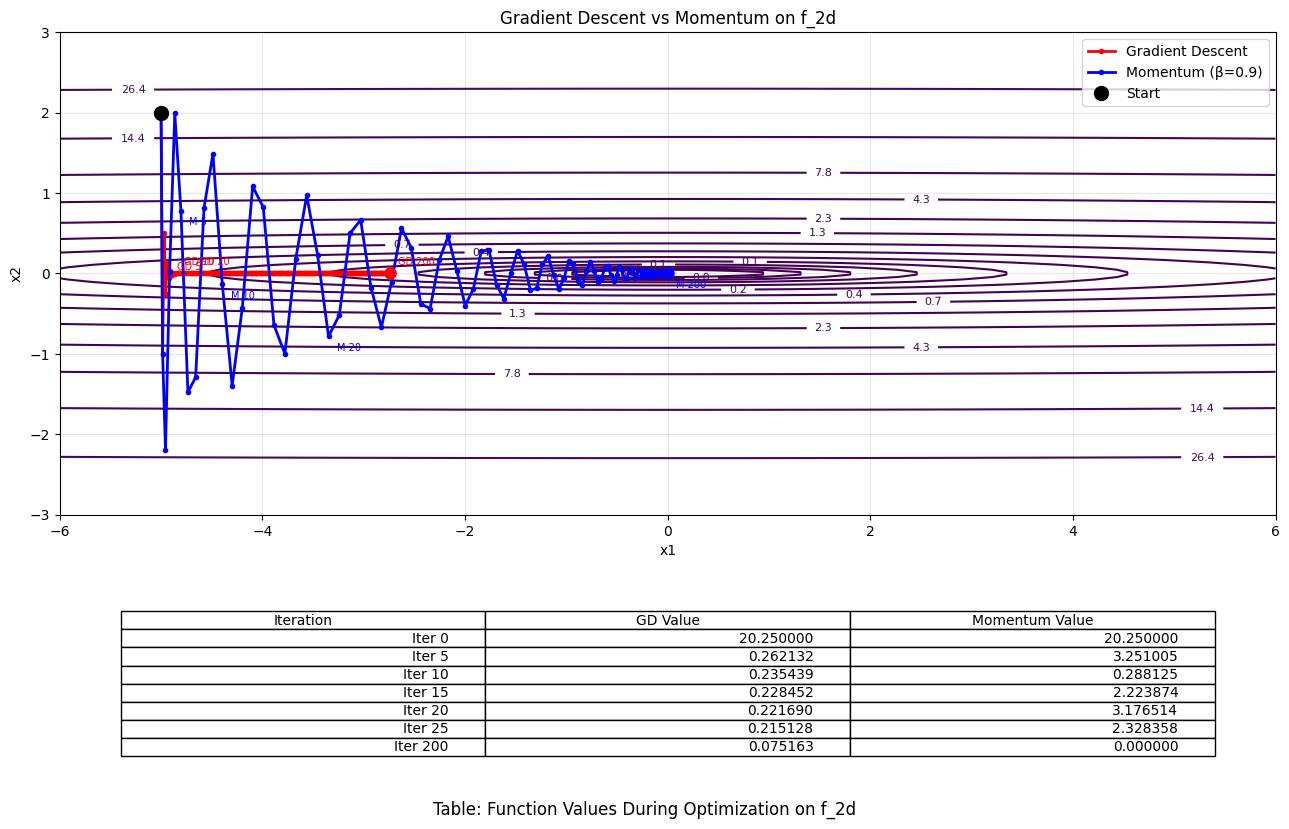

Gradient Descent:
Final position: (-2.7416, 0.0000)
Final value: 0.075163

Momentum:
Final position: (0.0003, -0.0000)
Final value: 0.000000


In [ ]:
# Sinh đường đi của GD
def path_gd(x0, y0, iters):
    x1, x2 = float(x0), float(y0)
    path = [(x1, x2)]
    for _ in range(iters):
        x1, x2, _, _ = gd_2d(x1, x2, 0, 0)
        path.append((float(x1), float(x2)))
    return np.array(path)

# Sinh đường đi của Momentum 
def path_momentum(x0, y0, iters):
    x1, x2 = float(x0), float(y0)
    v1 = v2 = 0.0
    path = [(x1, x2)]
    for _ in range(iters):
        x1, x2, v1, v2 = momentum_2d(x1, x2, v1, v2)
        path.append((float(x1), float(x2)))
    return np.array(path)

# Lưới contour cho f_2d
x = np.linspace(-6, 6, 200)
y = np.linspace(-3, 3, 200)
X, Y = np.meshgrid(x, y)
Z = f_2d(X, Y)

# Chọn điểm bắt đầu
x0, y0 = -5.0, 2.0

gd = path_gd(x0, y0, steps)
mom = path_momentum(x0, y0, steps)

plt.figure(figsize=(13, 10))

# Contour
levels = np.logspace(-2, 3, 20)
cs = plt.contour(X, Y, Z, levels=levels)
plt.clabel(cs, inline=True, fontsize=8)

# Đường đi
plt.plot(gd[:, 0], gd[:, 1], 'r.-', lw=2, ms=6, label='Gradient Descent')
plt.plot(mom[:, 0], mom[:, 1], 'b.-', lw=2, ms=6, label=f'Momentum (β={beta})')

# Điểm đầu / cuối
plt.plot(x0, y0, 'ko', ms=10, label='Start')
plt.plot(gd[-1, 0], gd[-1, 1], 'ro', ms=8)
plt.plot(mom[-1, 0], mom[-1, 1], 'bo', ms=8)

# Annotate vài mốc iteration
for i in [5, 10, 20, steps]:
    if i < len(gd):
        plt.annotate(f'GD {i}', (gd[i, 0], gd[i, 1]),
                     xytext=(6, 6), textcoords='offset points',
                     color='red', fontsize=7)
    if i < len(mom):
        plt.annotate(f'M {i}', (mom[i, 0], mom[i, 1]),
                     xytext=(6, -10), textcoords='offset points',
                     color='blue', fontsize=7)

plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(alpha=0.3)
plt.title('Gradient Descent vs Momentum on f_2d')
plt.legend()

iterations_to_show = [0, 5, 10, 15, 20, 25, steps]
table_data = []

for i in iterations_to_show:
    i_clamped = min(i, steps)  # khi i > số bước
    gd_val = f_2d(gd[i_clamped, 0], gd[i_clamped, 1])
    mom_val = f_2d(mom[i_clamped, 0], mom[i_clamped, 1])
    table_data.append([f"Iter {i_clamped}",
                       f"{gd_val:.6f}",
                       f"{mom_val:.6f}"])

table = plt.table(cellText=table_data,
                  colLabels=['Iteration', 'GD Value', 'Momentum Value'],
                  loc='bottom',
                  bbox=[0.05, -0.5, 0.9, 0.3])

fig = plt.gcf()
fig.text(0.5, 0.18,
         'Table: Function Values During Optimization on f_2d',
         ha='center', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.48)
plt.show()

# In ra kết quả cuối cùng
print("Gradient Descent:")
print(f"Final position: ({gd[-1, 0]:.4f}, {gd[-1, 1]:.4f})")
print(f"Final value: {f_2d(gd[-1, 0], gd[-1, 1]):.6f}")

print("\nMomentum:")
print(f"Final position: ({mom[-1, 0]:.4f}, {mom[-1, 1]:.4f})")
print(f"Final value: {f_2d(mom[-1, 0], mom[-1, 1]):.6f}")

## 5.2. Scalar function

To understand the theoretical limits of Momentum, we analyze a simple scalar quadratic function:
$$f(x) = \frac{\lambda}{2} x^2$$

## Using Gradient descent
$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$
This optimization converges at exponential rate since after t steps:
$$x_t = (1 - \eta \lambda)^t x_0$$

Behavior of convergence depends on the factor $(1 - \eta \lambda)$:
- If $|1 - \eta \lambda| < 1 ⇔ 0 < \eta \lambda < 2$ then $x_t → 0$: the algorithm converges
- If $|1 - \eta \lambda| > 1$ then $x → ∞$: the algorithm diverges
- If $|1 - \eta \lambda| = 1 → \eta \lambda = 2/ \eta \lambda = 0$: never converge (the value stays constant or oscillates without decay)

Let's look at the chart below showing how $x_t/ x_0$ change over time - how fast the variable converges to zero under different values of $1 - \eta \lambda$.

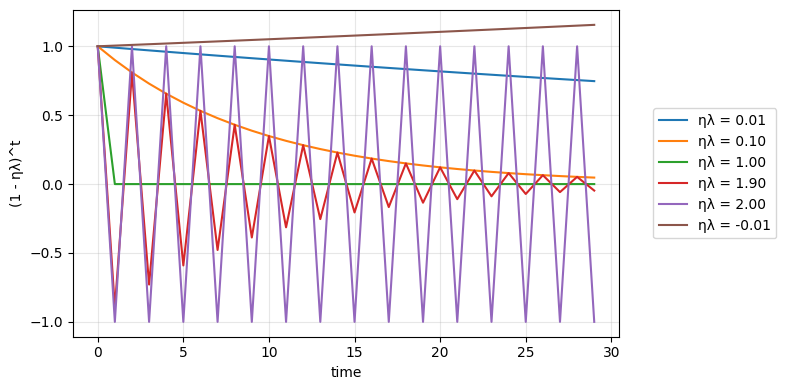

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

lambdas = [0.1, 1, 10, 19, 20, -0.05]
eta = 0.1

plt.figure(figsize=(8, 4))

for lam in lambdas:
    t = np.arange(30)
    curve = (1 - eta * lam) ** t
    plt.plot(t, curve, label=f'ηλ = {(eta * lam):.2f}')

plt.xlabel('time')
plt.ylabel('(1 - ηλ)^t')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Using momentum
$$
v_{t+1} = \beta v_t + \lambda x_t \\
x_{t+1} = x_t - \eta v_{t+1} = x_t - \eta \beta v_t + \eta \lambda x_t = -\eta \beta v_t + (1-\eta \lambda) x_t
$$

Converting to matrices:
$$
\begin{split}\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}.\end{split}
$$

We used $\mathbf{R}$ to denote the $2 \times 2$ governing convergence behavior. After $t$ steps the initial choice $[v_0, x_0]$ becomes $\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$. Hence, it is up to the eigenvalues of $\mathbf{R}$ to determine the speed of convergence.

Thus, after $t$ iterations:

$$\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}^t \begin{bmatrix} v_{0} \\ x_{0} \end{bmatrix}$$

The convergence behavior is completely determined by the eigenvalues $\sigma_1$ and $\sigma_2$ of the iteration matrix $\mathbf{R}$.

The method converges **if and only if** the spectral radius is strictly less than 1:
$$\rho(\mathbf{R}) = \max(|\sigma_1|, |\sigma_2|) < 1$$

This condition leads to the theoretical stability region for Momentum:
$$0 < \eta \lambda < 2 + 2\beta$$

This region is strictly larger than the stability region for standard Gradient Descent ($0 < \eta \lambda < 2$), demonstrating that the momentum term $\beta$ allows for a higher learning rate ($\eta$) while maintaining stability.

The convergence of $x_t$ is governed by the slowest decaying geometric mode, which is $\rho(\mathbf{R})$. The convergence rate is approximately.
$$\text{Convergence Rate} \sim \max(|\sigma_1|, |\sigma_2|)$$

When the eigenvalues of $\mathbf{R}$ form a complex conjugate pair, the dynamics become oscillatory. These controlled oscillations are an essential mechanism behind Momentum's ability to accelerate convergence and escape flat or shallow regions of the loss landscape.

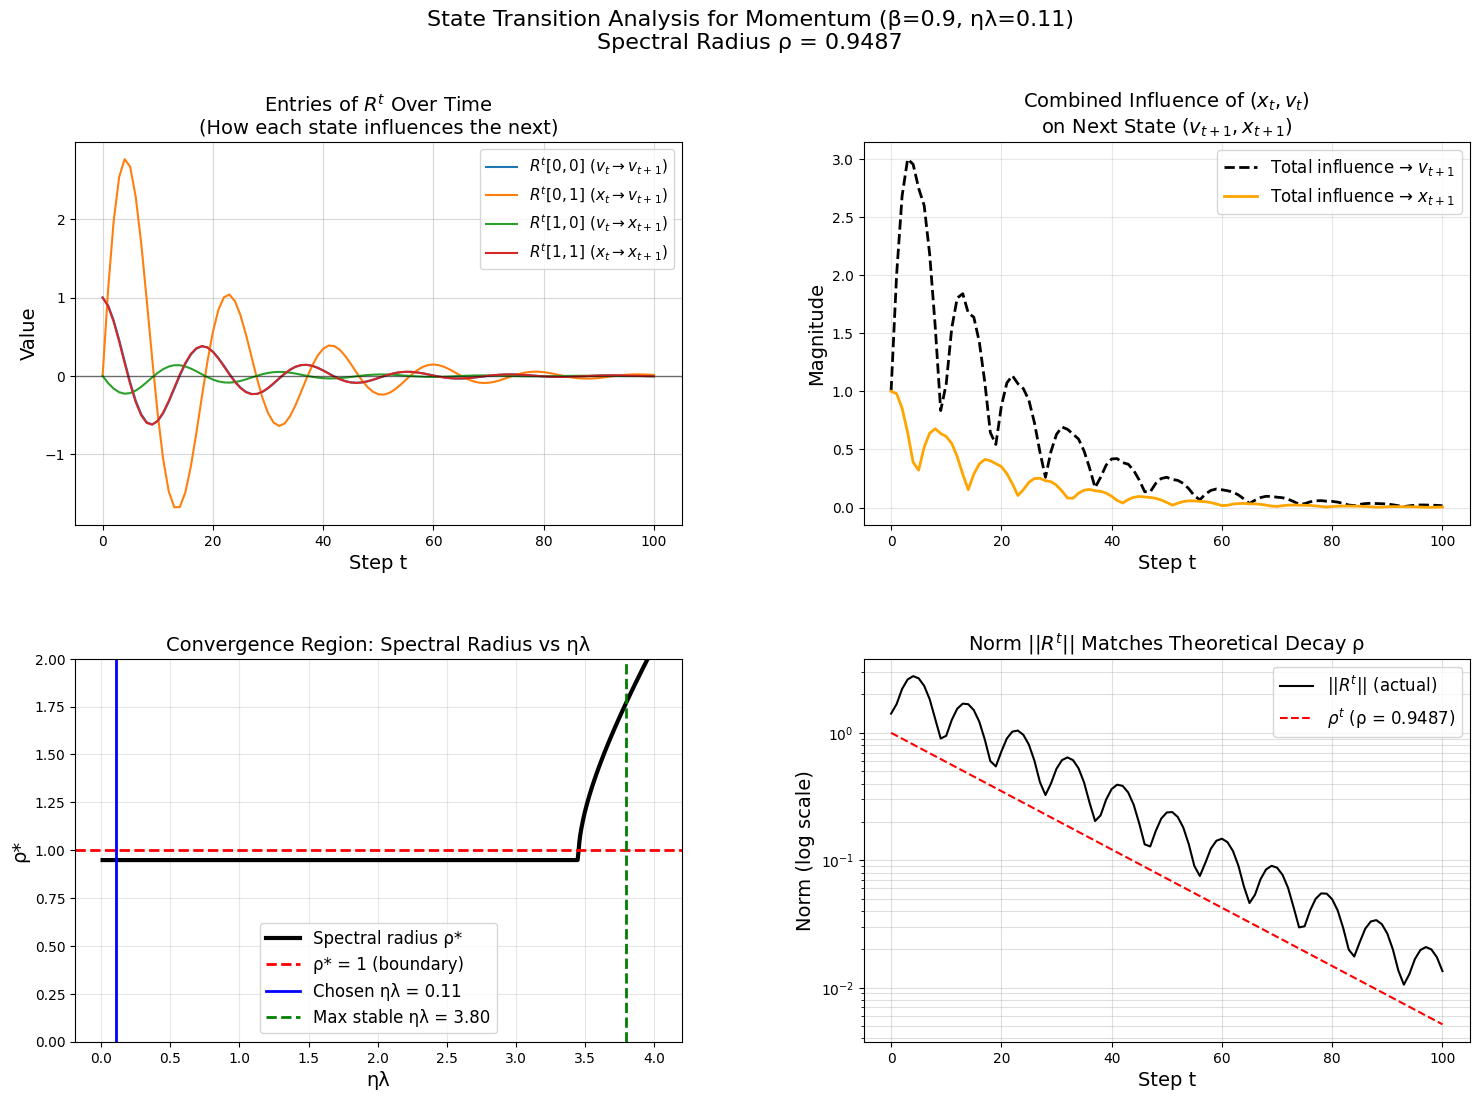

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#  PARAMETERS
lam = 1.1
eta = 0.1
beta = 0.9
steps = 100

# TRANSITION MATRIX R
R = np.array([[beta, lam],
              [-eta*beta, 1 - eta*lam]])

# Compute eigenvalues and spectral radius
eigvals = np.linalg.eigvals(R)
rho = np.max(np.abs(eigvals))

#  COMPUTE R^t
powers = np.zeros((steps+1, 2, 2))
powers[0] = np.eye(2)
for tt in range(1, steps+1):
    powers[tt] = powers[tt-1] @ R

r11 = powers[:, 0, 0]
r12 = powers[:, 0, 1]
r21 = powers[:, 1, 0]
r22 = powers[:, 1, 1]
norms = np.linalg.norm(powers, axis=(1,2))
t = np.arange(steps+1)

#  PLOT 4 PANELS (CLEAN LAYOUT)
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.35, wspace=0.3)

# FIGURE 1 — R^t elements
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t, r11, linewidth=1.5, label='$R^t[0,0]$ ($v_t \\to v_{t+1}$)')
ax1.plot(t, r12, linewidth=1.5, label='$R^t[0,1]$ ($x_t \\to v_{t+1}$)')
ax1.plot(t, r21, linewidth=1.5, label='$R^t[1,0]$ ($v_t \\to x_{t+1}$)')
ax1.plot(t, r22, linewidth=1.5, label='$R^t[1,1]$ ($x_t \\to x_{t+1}$)')
ax1.axhline(0, color='k', linewidth=1, alpha=0.5)
ax1.set_title("Entries of $R^t$ Over Time\n(How each state influences the next)", fontsize=14)
ax1.set_xlabel("Step t", fontsize=14)
ax1.set_ylabel("Value", fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.5)

# FIGURE 4 — Combined Influence
ax4 = fig.add_subplot(gs[0, 1])
influence_v = np.abs(r11) + np.abs(r12)
influence_x = np.abs(r21) + np.abs(r22)
ax4.plot(t, influence_v, 'k--', linewidth=2, label='Total influence → $v_{t+1}$')
ax4.plot(t, influence_x, 'orange', linewidth=2, label='Total influence → $x_{t+1}$')
ax4.set_title("Combined Influence of ($x_t, v_t$)\non Next State ($v_{t+1}, x_{t+1}$)", fontsize=14)
ax4.set_xlabel("Step t", fontsize=14)
ax4.set_ylabel("Magnitude", fontsize=14)
ax4.legend(fontsize=12)
ax4.grid(alpha=0.3)

# FIGURE 2 — Spectral Radius vs ηλ
ax2 = fig.add_subplot(gs[1, 0])
eta_range = np.linspace(0.01, 4.0, 600)
rhos = [np.max(np.abs(np.linalg.eigvals(np.array([[beta, lam], [-ev*beta, 1 - ev*lam]])))) for ev in eta_range]
ax2.plot(eta_range, rhos, 'k-', linewidth=3, label='Spectral radius ρ*')
ax2.axhline(1, color='red', linestyle='--', linewidth=2, label='ρ* = 1 (boundary)')
ax2.axvline(eta * lam, color='blue', linewidth=2, label=f'Chosen ηλ = {eta*lam:.2f}')
ax2.axvline(2*(1+beta), color='green', linestyle='--', linewidth=2, label=f'Max stable ηλ = {2*(1+beta):.2f}')
ax2.set_title("Convergence Region: Spectral Radius vs ηλ", fontsize=14)
ax2.set_xlabel("ηλ", fontsize=14)
ax2.set_ylabel("ρ*", fontsize=14)
ax2.set_ylim(0, 2)
ax2.legend(fontsize=12)
ax2.grid(alpha=0.3)

# FIGURE 3 — Norm R^t vs ρ^t (fixed label with escaped braces)
ax3 = fig.add_subplot(gs[1, 1])
ax3.semilogy(t, norms, 'k-', linewidth=1.5, label=r'$||R^t||$ (actual)')


ax3.semilogy(
    t,
    rho**t,
    'r--',
    linewidth=1.5,
    label=rf'$\rho^{{t}}$ (ρ = {rho:.4f})'
)

ax3.set_title("Norm $||R^t||$ Matches Theoretical Decay ρ", fontsize=14)
ax3.set_xlabel("Step t", fontsize=14)
ax3.set_ylabel("Norm (log scale)", fontsize=14)
ax3.legend(fontsize=12)
ax3.grid(True, which="both", alpha=0.4)

plt.suptitle(
    f"State Transition Analysis for Momentum (β={beta}, ηλ={eta*lam:.2f})\n"
    f"Spectral Radius ρ = {rho:.4f}",
    fontsize=16,
    y=0.97
)

plt.subplots_adjust(top=0.86, hspace=0.6, wspace=0.6)
plt.show()

## 5.3. Benchmark on MNIST dataset


Finally, we'll test the algorithm on a real-world high-dimensional non-convex problem: handwritten digit classification

  * **Dataset:** MNIST (60k train, 10k test).
  * **Model:** 3-layer MLP (ReLU activations).
  * **Comparison:**
    * Vanilla SGD: `β = 0.0`.
    * SGD + Momentum: `β = 0.9`.
    * SGD + High Momentum: `β = 0.99`.

### Implementation Check: From Scratch vs. PyTorch API

Before running the benchmark, we verify our understanding of the mechanism of PyTorch's `optim.SGD` by implementing a custom update function from scratch and comparing the results.

In [ ]:
import torch
import torch.optim as optim

def custom_sgd_momentum_step(params, velocity_states, lr, momentum):
    """
    Manual implementation of SGD with Momentum step.
    Formula:
        v_{t+1} = momentum * v_t + g_t
        w_{t+1} = w_t - lr * v_{t+1}
    """
    with torch.no_grad():
        for i, p in enumerate(params):
            if p.grad is None:
                continue

            # Initialize velocity if needed
            if i not in velocity_states:
                velocity_states[i] = torch.zeros_like(p.data)

            # Update Velocity (In-place to save memory)
            # v = beta * v + g
            velocity_states[i].mul_(momentum).add_(p.grad.data)

            # Update Parameters
            # w = w - lr * v
            p.data.sub_(velocity_states[i], alpha=lr)

def verify_implementation():
    print("--- White-box Verification: Custom Code vs PyTorch ---")

    # 1. Setup Identical Tensors
    # Weights initialized to [1.0, 2.0]
    w_custom = torch.tensor([1.0, 2.0], requires_grad=True)
    w_torch  = torch.tensor([1.0, 2.0], requires_grad=True)

    # Fake Gradients fixed to [0.1, 0.2]
    fake_grad = torch.tensor([0.1, 0.2])
    w_custom.grad = fake_grad.clone()
    w_torch.grad  = fake_grad.clone()

    # Hyperparameters
    lr = 0.01
    momentum = 0.9

    # 2. Run Custom Step
    velocity_states = {}
    custom_sgd_momentum_step([w_custom], velocity_states, lr, momentum)

    # 3. Run PyTorch Step
    optimizer = optim.SGD([w_torch], lr=lr, momentum=momentum)
    optimizer.step()

    # 4. Compare Results
    print(f"Custom Params: {w_custom.data}")
    print(f"PyTorch Params: {w_torch.data}")

    if torch.allclose(w_custom, w_torch, atol=1e-8):
        print("Result: Our custom implementation matches PyTorch's logic exactly!")
    else:
        print("Result: The implementations differ!")

verify_implementation()

--- White-box Verification: Custom Code vs PyTorch ---
Custom Params: tensor([0.9990, 1.9980])
PyTorch Params: tensor([0.9990, 1.9980])
Result: Our custom implementation matches PyTorch's logic exactly!


### Prepare the dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# 2. Data Preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Using Mini-batch size 64 for all experiments
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Running on device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.98MB/s]


### Model definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Create training function

In [ ]:
def train_experiment(name, lr, momentum, epochs=10):
    print(f"--- Starting Experiment: {name} (lr={lr}, beta={momentum}) ---")

    # Re-initialize model to ensure fair start
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            # Reset gradients to zero
            optimizer.zero_grad()

            # Perform forward pass
            output = model(data)

            # Calculate the loss value
            loss = criterion(output, target)
            # Perform backward pass and update weights
            loss.backward()
            optimizer.step()

            # Accumulate weighted loss for the epoch
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        acc = 100 * correct / total
        accuracy_history.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")

    return loss_history, accuracy_history


### Begin training

In [ ]:
epochs = 10 # we use small epochs for quick demo
lr = 0.01

loss_sgd, acc_sgd = train_experiment("Vanilla SGD", lr, 0.0, epochs)
loss_mom9, acc_mom9 = train_experiment("Momentum 0.9", lr, 0.9, epochs)
loss_mom99, acc_mom99 = train_experiment("Momentum 0.99", lr, 0.99, epochs)

--- Starting Experiment: Vanilla SGD (lr=0.01, beta=0.0) ---
Epoch 1/10 | Loss: 0.8095 | Test Acc: 90.03%
Epoch 2/10 | Loss: 0.3171 | Test Acc: 92.12%
Epoch 3/10 | Loss: 0.2632 | Test Acc: 92.79%
Epoch 4/10 | Loss: 0.2263 | Test Acc: 93.77%
Epoch 5/10 | Loss: 0.1977 | Test Acc: 94.50%
Epoch 6/10 | Loss: 0.1745 | Test Acc: 95.36%
Epoch 7/10 | Loss: 0.1559 | Test Acc: 95.47%
Epoch 8/10 | Loss: 0.1408 | Test Acc: 96.01%
Epoch 9/10 | Loss: 0.1284 | Test Acc: 96.23%
Epoch 10/10 | Loss: 0.1177 | Test Acc: 96.40%
--- Starting Experiment: Momentum 0.9 (lr=0.01, beta=0.9) ---
Epoch 1/10 | Loss: 0.3230 | Test Acc: 95.74%
Epoch 2/10 | Loss: 0.1147 | Test Acc: 97.03%
Epoch 3/10 | Loss: 0.0783 | Test Acc: 97.25%
Epoch 4/10 | Loss: 0.0574 | Test Acc: 97.81%
Epoch 5/10 | Loss: 0.0455 | Test Acc: 97.92%
Epoch 6/10 | Loss: 0.0368 | Test Acc: 97.71%
Epoch 7/10 | Loss: 0.0288 | Test Acc: 97.79%
Epoch 8/10 | Loss: 0.0217 | Test Acc: 97.73%
Epoch 9/10 | Loss: 0.0180 | Test Acc: 97.78%
Epoch 10/10 | Loss: 0

### Visualization

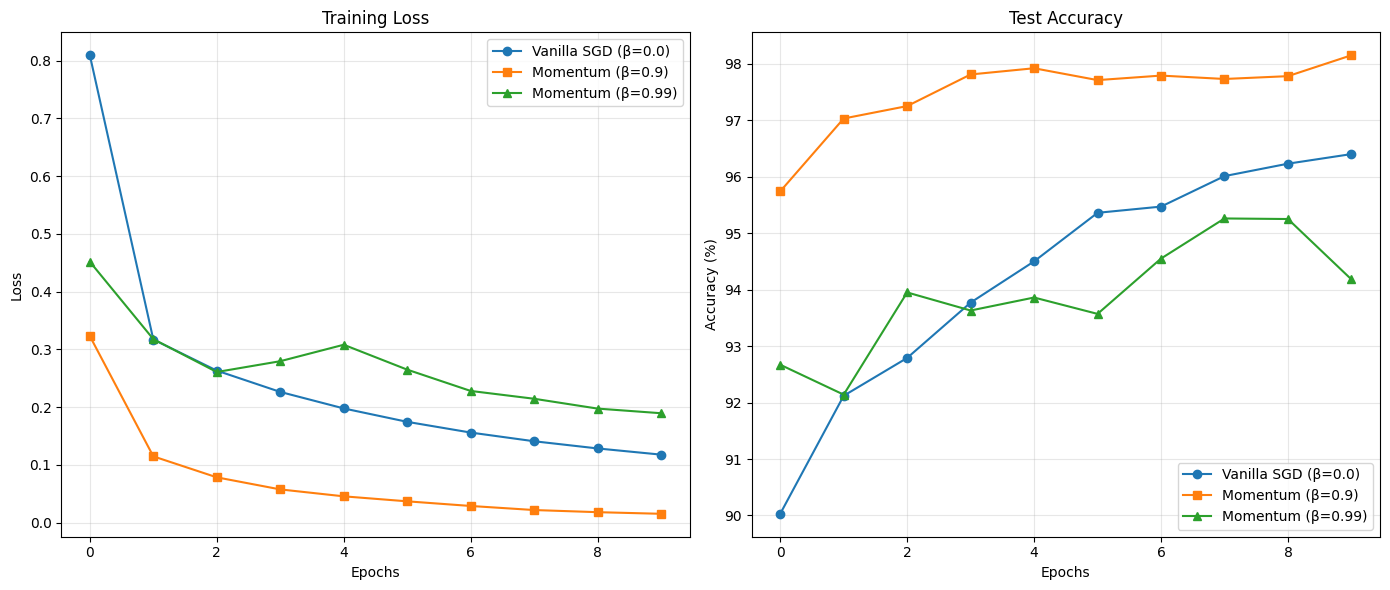

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Plot Training Loss
ax1.plot(loss_sgd, 'o-', label='Vanilla SGD (β=0.0)')
ax1.plot(loss_mom9, 's-', label='Momentum (β=0.9)')
ax1.plot(loss_mom99, '^-', label='Momentum (β=0.99)')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot Test Accuracy
ax2.plot(acc_sgd, 'o-', label='Vanilla SGD (β=0.0)')
ax2.plot(acc_mom9, 's-', label='Momentum (β=0.9)')
ax2.plot(acc_mom99, '^-', label='Momentum (β=0.99)')
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

Analysis:

  * **Vanilla SGD ($\beta=0$):** The loss decreases steadily but represents the slowest convergence. In high-dimensional space like MNIST, the optimization surface contains many "ravines" (ill-conditioned regions). SGD struggles to navigate these efficiently without the velocity term.
  * **Momentum ($\beta=0.9$):** Demonstrates a **superior convergence rate**. The loss drops significantly sharper in the first few epochs. The momentum term helps the optimizer build up speed in consistent directions (dimensions with low curvature) while dampening the noise from stochastic mini-batches.
  * **High Momentum ($\beta=0.99$):** While potentially faster initially, it carries a risk. The effective memory horizon is $\frac{1}{1-0.99} \approx 100$ steps. This excessive inertia can cause the optimizer to **overshoot** narrow minima or oscillate around the optimum before settling, which is why it requires careful learning rate tuning (often a smaller $\eta$ is needed when $\beta \to 1$).

# 6. Exercises


## Q1


### Problem statement
Use other combinations of momentum hyperparameters and learning rates and observe and analyze the different experimental results.

### Analytic Solution

We will reuse the function from **section 5.1**:

$$
f(x_1, x_2) = 0.01x_1^2 + 5x_2^2.
$$

Then we calculate gradient descent:

$$
\frac{\partial f}{\partial x_1} = 0.02x_1,
\quad
\frac{\partial f}{\partial x_2} = 10x_2.
$$


After that, we apply momentum algorithm:

$$
\begin{cases}
v_{1,t+1} = \beta v_{1,t} + 0.02x_{1,t} \\
v_{2,t+1} = \beta v_{2,t} + 10x_{2,t} \\
x_{1,t+1} = x_{1,t} - \eta v_{1,t+1} \\
x_{2,t+1} = x_{2,t} - \eta v_{2,t+1}
\end{cases}
$$

Let's implement by coding.

### First, we convert the above formulas into code as follows:

In [ ]:
def f_2d(x1, x2):
    return 0.01 * x1**2 + 5 * x2**2

def train_simulation(eta, beta, epochs=20):
    x1, x2 = -5.0, -2.0
    v1, v2 = 0.0, 0.0

    for _ in range(epochs):
        g1 = 0.02 * x1
        g2 = 10.0 * x2

        v1 = beta * v1 + g1
        v2 = beta * v2 + g2

        x1 = x1 - eta * v1
        x2 = x2 - eta * v2


    return f_2d(x1, x2)


### We initialize two lists of desired learning rate and momentum values; here, we will take learning rates from 0.001 to 0.4, and momentum values from 0 to 0.99. Subsequently, the data needs to be normalized to the range of 0-100 for ease in plotting the heatmap

In [ ]:
import numpy as np

etas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4] # Learning rate
betas = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]    # Momentum value

loss_matrix = np.zeros((len(etas), len(betas)))

for i, eta in enumerate(etas):
    for j, beta in enumerate(betas):
        loss_matrix[i, j] = train_simulation(eta, beta, epochs=30)

# 5. Normalize result, max at 100
loss_matrix = np.clip(loss_matrix, 0, 100)

### Visualize the heatmap

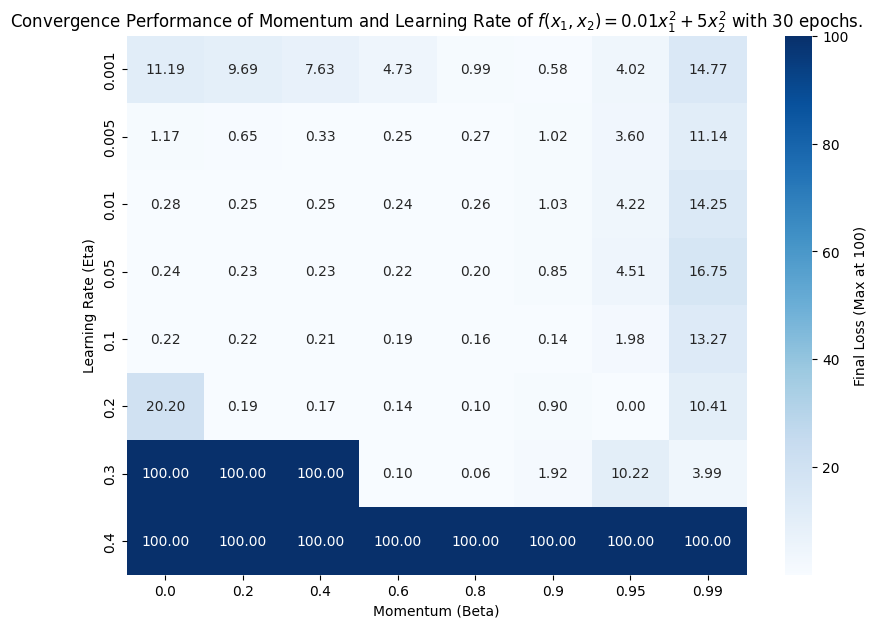

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(10, 7))
sns.heatmap(loss_matrix, annot=True, fmt=".2f",
            xticklabels=betas, yticklabels=etas,
            cmap="Blues",
            cbar_kws={'label': 'Final Loss (Max at 100)'})

plt.xlabel('Momentum (Beta)')
plt.ylabel('Learning Rate (Eta)')
plt.title('Convergence Performance of Momentum and Learning Rate of $f(x_1, x_2) = 0.01x_1^2 + 5x_2^2$ with 30 epochs.')
plt.show()

### Conclusion

From the heatmap visualizing the relationship between the **Learning Rate ($\eta$)** and **Momentum ($\beta$)** for the loss function $f(x_1, x_2) = 0.01x_1^2 + 5x_2^2$ over **30 epochs**, we draw the following conclusions:

*a. The Trade-off*

**When the Learning Rate is Low** ($\eta \le 0.01$): Increasing the **Momentum** value to high levels (0.9, 0.95, or even 0.99) significantly **improves the Loss**. For example, at $\eta=0.001$, the loss without Momentum ($\beta=0$) is $11.19$, but with $\beta=0.9$ the loss sharply drops to $0.58$.
    * $\rightarrow$ ***Momentum compensates for the slow learning speed.***

**When the Learning Rate is High** ($\eta \ge 0.2$): We are forced to **reduce the Momentum** to prevent the optimization process from "overshooting" the minimum (the "hole"). Notably, at $\eta=0.3$, the best result is achieved with $\beta=0.8$ (Loss $0.06$), but increasing $\beta$ to $0.9$ immediately worsens the Loss ($1.92$).

*b. Excessive learning rate leads to divergence*

In the final rows ($\eta = 0.3, 0.4$), the model begins to **diverge** (the Loss hits the ceiling of $100.0$).

At $\eta=0.4$, the model reaches the $100.0$ threshold for almost all **Momentum** values. This confirms that when the **Learning Rate is too large**, exceeding the curvature of the function, Momentum not only fails to save the situation but often makes it worse due to the **amplified oscillation** (the inertia pushing the parameters too far).


Therefore, based on this experiment using the specified objective function, the **most optimal parameter pair (Sweet Spot)** is **$\eta=0.2$ and $\beta=0.95$** (Loss $= 0.00$), rather than the default values of $0.01/\,0.9$ often cited in textbooks. This highlights the critical importance of performing a **Grid Search** to find parameters suitable for a specific **Loss Surface**.

## Q2

### Problem statement
Try out gradient descent and momentum for a quadratic problem where you have multiple eigenvalues, i.e.,
$$
f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2, e.g. \lambda_i = 2^{-i}
$$

Plot how the values of x decrease for the initialization $x_i=1$.



### Analytic Solution

We will perform the update steps for both **Gradient Descent** and **Momentum** starting with the initial condition $x_0 = 1$ for all $x_i$, and observe the change in the values of $x_i$ over each update step.

The Gradient Descent update follows the formula:

$$
x_{i,t+1} = (1 - \eta \lambda_i) x_{i,t}
$$


The Momentum update follows the formulas:

$$
v_{i,t+1} = \beta v_{i,t} + \lambda_i x_{i,t}
$$

$$
x_{i,t+1} = x_{i,t} - \eta v_{i,t+1}
$$

Where:
* $x_0 = 1$ for all $x_i$,
* The learning rate $\eta = 0.1$,
* The momentum coefficient $\beta = 0.9$.
* *Note: For the Momentum calculation, the initial velocity is typically $v_{i,0} = 0$.*


**Objectives:**

1.  Calculate the change in $x_i$ over each step for both methods (GD and Momentum).
2.  Plot the decay of the $x_i$ values over time.


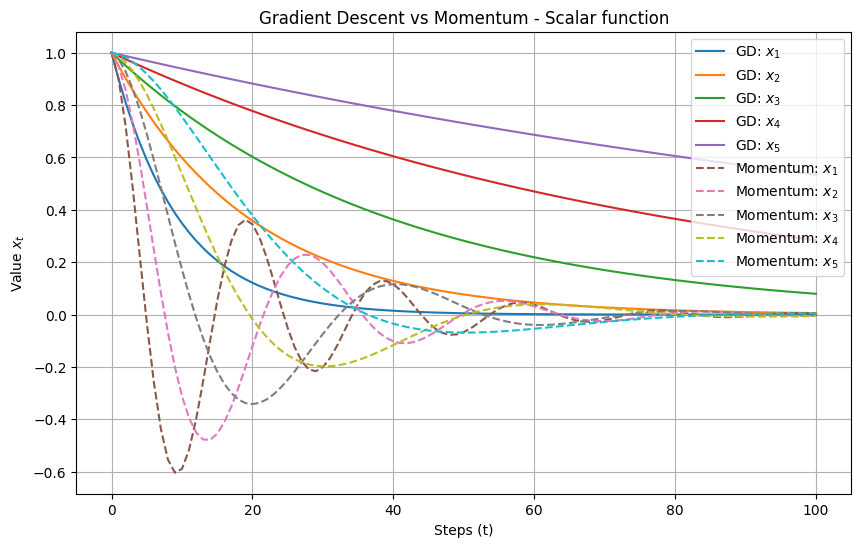

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Hàm mất mát f(x) = 1/2 * Σ λ_i * x_i^2
def f(x, lambdas):
    return 0.5 * np.sum(lambdas * x**2)

# Gradient của f(x) (đạo hàm theo từng biến)
def grad_f(x, lambdas):
    return lambdas * x

# Cập nhật bằng Gradient Descent
def gradient_descent(lambdas, eta, x_init, num_steps):
    x = x_init
    x_vals = [x.copy()]

    for t in range(num_steps):
        grad = grad_f(x, lambdas)
        x = x - eta * grad  # Cập nhật
        x_vals.append(x.copy())

    return np.array(x_vals)

# Cập nhật với Momentum
def momentum(lambdas, eta, beta, x_init, num_steps):
    x = x_init
    v = np.zeros_like(x)  # Vận tốc ban đầu
    x_vals = [x.copy()]

    for t in range(num_steps):
        grad = grad_f(x, lambdas)
        v = beta * v + grad  # Cập nhật vận tốc
        x = x - eta * v  # Cập nhật x
        x_vals.append(x.copy())

    return np.array(x_vals)

# Thiết lập tham số
num_steps = 100  # Số bước lặp
eta = 0.1  # Tốc độ học
beta = 0.9  # Hệ số momentum
x_init = np.ones(5)  # Khởi tạo x = [1, 1, 1, 1, 1] (5 chiều)

# λ_i = 2^-i
lambdas = np.array([2**-i for i in range(5)])

# Thực hiện Gradient Descent
x_gd = gradient_descent(lambdas, eta, x_init, num_steps)

# Thực hiện Momentum
x_momentum = momentum(lambdas, eta, beta, x_init, num_steps)

# Vẽ đồ thị
plt.figure(figsize=(10, 6))

# Vẽ đồ thị Gradient Descent
for i in range(x_gd.shape[1]):
    plt.plot(x_gd[:, i], label=f"GD: $x_{i+1}$")

# Vẽ đồ thị Momentum
for i in range(x_momentum.shape[1]):
    plt.plot(x_momentum[:, i], label=f"Momentum: $x_{i+1}$", linestyle='--')

plt.xlabel(r"Steps (t)")
plt.ylabel(r"Value $x_t$")
plt.title('Gradient Descent vs Momentum - Scalar function')
plt.legend()
plt.grid(True)
plt.show()

## Q3

### Problem statement
Derive the minimizer and minimum value of the quadratic  
$$ h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b, \quad \mathbf{Q} \succ 0. $$



### Analytic solution

Since $\mathbf{Q}$ is symmetric positive definite, $h(\mathbf{x})$ is strictly convex and attains a unique minimum where the gradient vanishes:  
$$ \nabla h(\mathbf{x}) = \mathbf{Q}\mathbf{x} + \mathbf{c} = 0 \quad \Rightarrow \quad \mathbf{x}^* = -\mathbf{Q}^{-1}\mathbf{c}. $$

Substituting $\mathbf{x}^*$ into $h(\mathbf{x})$ gives  
$$
\begin{align*}
h(\mathbf{x}^*) &= \frac{1}{2} (\mathbf{x}^*)^\top \mathbf{Q} \mathbf{x}^* + \mathbf{c}^\top \mathbf{x}^* + b \\
&= \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{Q} \mathbf{Q}^{-1} \mathbf{c} - \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c} + b \\
&= \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c} - \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c} + b \\
&= b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.
\end{align*}
$$

Then, we have:
- Minimizer: $\mathbf{x}^* = -\mathbf{Q}^{-1}\mathbf{c}$
- Minimum value: $h(\mathbf{x}^*) = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1}\mathbf{c}$

### Numerical verification

Let  
$$ \mathbf{Q} = \begin{bmatrix} 3 & 1 \\ 1 & 2 \end{bmatrix}, \quad
\mathbf{c} = \begin{bmatrix} -2 \\ -6 \end{bmatrix}, \quad b = 0. $$

First, compute $\det\mathbf{Q}$ (for 2x2 matrix: $ad - bc$):  
$$ \det\mathbf{Q} = 3\cdot2 - 1\cdot1 = 6 - 1 = 5. $$

The inverse is  
$$ \mathbf{Q}^{-1} = \frac{1}{5} \begin{bmatrix} 2 & -1 \\ -1 & 3 \end{bmatrix}. $$

The minimizer is  
$$ \mathbf{x}^* = -\mathbf{Q}^{-1}\mathbf{c}
= -\frac{1}{5} \begin{bmatrix} 2 & -1 \\ -1 & 3 \end{bmatrix} \begin{bmatrix} -2 \\ -6 \end{bmatrix}
= -\frac{1}{5} \begin{bmatrix} 2 \\ -16 \end{bmatrix}
= \begin{bmatrix} -0.4 \\ 3.2 \end{bmatrix}. $$

The scalar $\mathbf{c}^\top \mathbf{Q}^{-1}\mathbf{c}$ is  
$$ \mathbf{Q}^{-1}\mathbf{c} = \frac{1}{5} \begin{bmatrix} 2 \\ -16 \end{bmatrix} = \begin{bmatrix} 0.4 \\ -3.2 \end{bmatrix}, \quad
\mathbf{c}^\top (\mathbf{Q}^{-1}\mathbf{c}) = (-2)(0.4) + (-6)(-3.2) = 18.4. $$

Thus  
$$ h(\mathbf{x}^*) = -\frac{1}{2} \cdot 18.4 = -9.2. $$

Direct substitution of $\mathbf{x}^* = \begin{bmatrix} -0.4 \\ 3.2 \end{bmatrix}^\top$ into the original $h(\mathbf{x})$ yields the same value $-9.2$, confirming the closed-form expressions.

**Final answer for the example**  
- Minimizer: $\mathbf{x}^* = \begin{bmatrix} -0.4 \\ 3.2 \end{bmatrix}$  
- Minimum value: $h(\mathbf{x}^*) = -9.2$

Minimizer: x* = (-0.4, 3.2)
Minimum value: h(x*) = -9.2


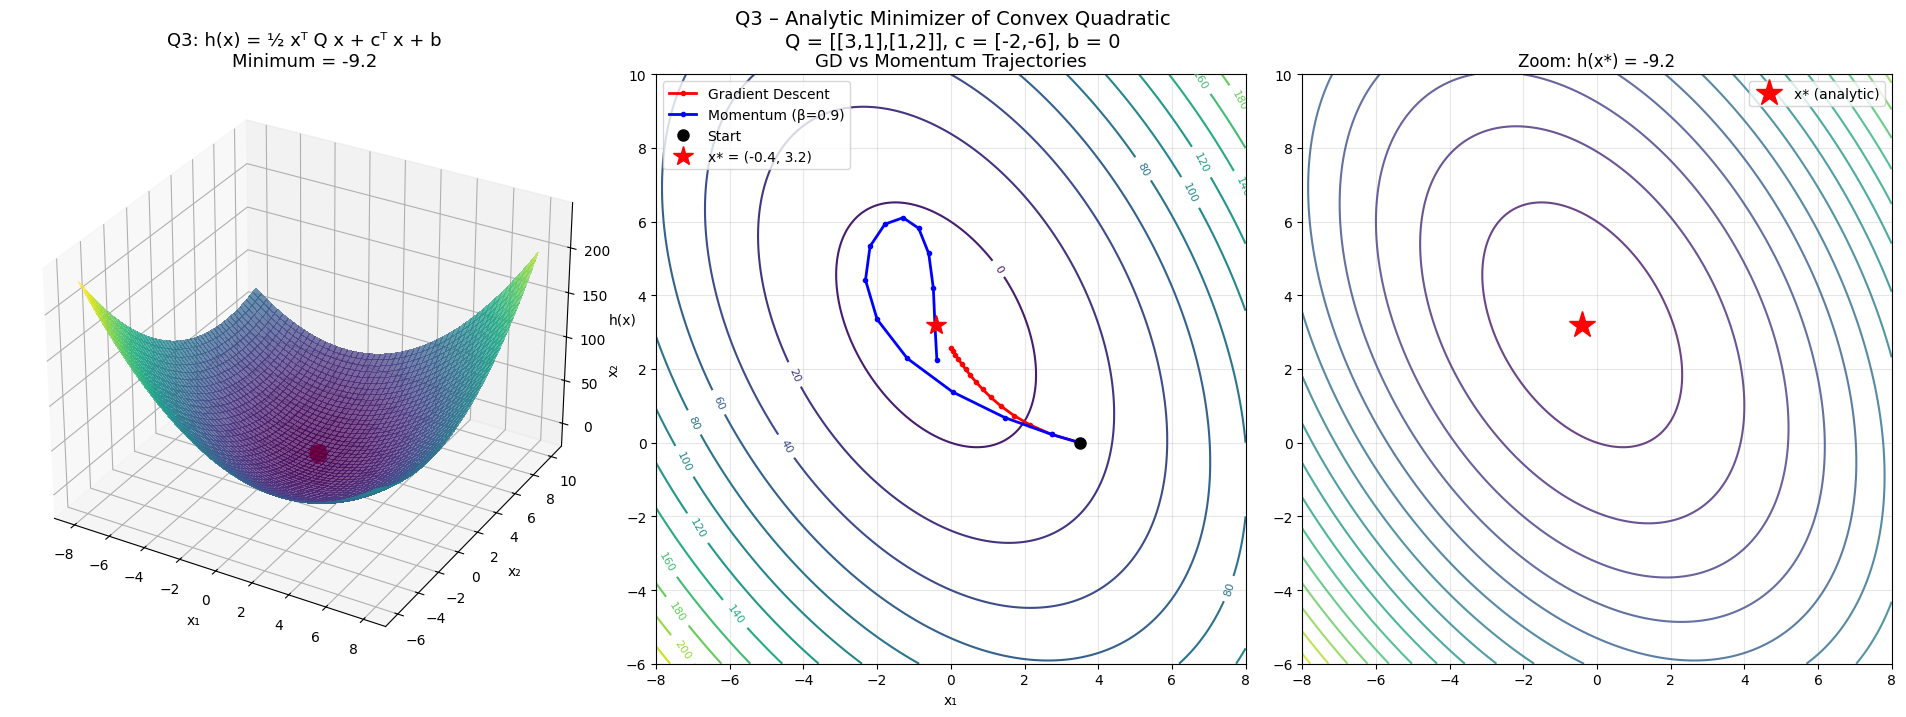

In [ ]:
# Q3
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Parameters from Q3
Q = np.array([[3.0, 1.0],
              [1.0, 2.0]])
c = np.array([-2.0, -6.0])
b = 0.0

# Analytic solution
x_star = -np.linalg.inv(Q) @ c
h_min = b - 0.5 * c.T @ np.linalg.inv(Q) @ c
print(f"Minimizer: x* = ({x_star[0]:.1f}, {x_star[1]:.1f})")
print(f"Minimum value: h(x*) = {h_min:.1f}")

# CORRECT vectorized h(x,y) using einsum (BEST PRACTICE)
def h(x, y):
    # x, y are (400,400) grids → stack → (2,400,400)
    vec = np.stack([x, y])
    quadratic = np.einsum('i...,ij,j...->...', vec, Q, vec)   # vec.T @ Q @ vec
    linear = np.einsum('i,i...->...', c, vec)                 # c.T @ vec
    return 0.5 * quadratic + linear + b

# Gradient (for optimisation)
def grad_h(vec):
    return Q @ vec + c

# Grid
x = np.linspace(-8, 8, 700)
y = np.linspace(-6, 10, 700)
X, Y = np.meshgrid(x, y)
Z = h(X, Y)

# Run GD and Momentum
def gd_path(x0, eta=0.09, steps=14):
    path = [x0.copy()]
    x = x0.copy()
    for _ in range(steps):
        x = x - eta * grad_h(x)
        path.append(x.copy())
    return np.array(path)

def momentum_path(x0, eta=0.09, beta=0.9, steps=14):
    path = [x0.copy()]
    x = x0.copy(); v = np.zeros(2)
    for _ in range(steps):
        v = beta * v + eta * grad_h(x)
        x = x - v
        path.append(x.copy())
    return np.array(path)

start = np.array([3.5, 0.0])
gd_traj = gd_path(start)
mom_traj = momentum_path(start)

# ============ PLOT ============
fig = plt.figure(figsize=(19, 7))

# 3D Surface
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=False)
ax1.scatter(*x_star, h_min, color='red', s=150, label='x* (analytic)', depthshade=False)
ax1.set_title('Q3: h(x) = ½ xᵀ Q x + cᵀ x + b\nMinimum = -9.2', fontsize=13)
ax1.set_xlabel('x₁'); ax1.set_ylabel('x₂'); ax1.set_zlabel('h(x)')

# Contour + Trajectories
ax2 = fig.add_subplot(132)
cp = ax2.contour(X, Y, Z, levels=15, cmap='viridis')
ax2.clabel(cp, inline=True, fontsize=8)
ax2.plot(gd_traj[:,0], gd_traj[:,1], 'r.-', label='Gradient Descent', lw=2, ms=6)
ax2.plot(mom_traj[:,0], mom_traj[:,1], 'b.-', label='Momentum (β=0.9)', lw=2, ms=6)
ax2.plot(start[0], start[1], 'ko', label='Start', ms=8)
ax2.plot(x_star[0], x_star[1], 'r*', ms=15, label='x* = (-0.4, 3.2)')
ax2.set_title('GD vs Momentum Trajectories', fontsize=13)
ax2.set_xlabel('x₁'); ax2.set_ylabel('x₂')
ax2.legend(); ax2.grid(alpha=0.3)
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax2.axis('equal')
ax2.set_aspect('equal', adjustable='box')
ax2.margins(0)
# Zoom at minimum
ax3 = fig.add_subplot(133)
ax3.contour(X, Y, Z, levels=20, cmap='viridis', alpha=0.8)
ax3.plot(x_star[0], x_star[1], 'r*', ms=20, label='x* (analytic)')
ax3.set_title('Zoom: h(x*) = -9.2')
ax3.legend(); ax3.grid(alpha=0.3)
ax3.set_xlim(-8, 8)
ax3.set_ylim(-6, 10)
ax3.axis('equal')
ax3.set_aspect('equal', adjustable='box')
ax3.margins(0)
plt.suptitle('Q3 – Analytic Minimizer of Convex Quadratic\n'
             'Q = [[3,1],[1,2]], c = [-2,-6], b = 0', fontsize=14, y=0.98)
plt.tight_layout(pad=0.5)
plt.show()

## Q4

### Problem statement

What changes when we perform stochastic gradient descent with momentum? What happens when we use minibatch stochastic gradient descent with momentum? Experiment with the parameters?

### 1. What changes when we perform Stochastic gradient descent with momentum?
Stochastic Gradient Descent (SGD) updates parameters using noisy gradients from one sample (or a mini-batch).
- Without Momentum:
$$\mathbf{x}_{t+1} =\mathbf{x}_t - \eta \nabla_\mathbf{x} f(\mathbf{x}_t)
$$

- With Momentum:
$$v_{t+1} = \beta v_t - \nabla_\mathbf{x} f(\mathbf{x}_t) \\
\mathbf{x}_{t+1} = \mathbf{x}_t + \eta v_{t+1}
$$

**Key changes**
- Key changes introduced by Momentum
- Smoother updates - noise is filtered by the velocity term.
- Faster convergence, especially in shallow or flat regions.
- Reduced oscillation along steep directions.
- Better navigation through plateaus, narrow valleys, or weak curvature regions.

**Why this happens**
- Momentum keeps a velocity vector that accumulates past gradients.
- This memory causes gradients to reinforce each other in consistent directions.
- Oscillations are damped because updates no longer respond directly to a noisy gradient.
- The algorithm makes longer steps in beneficial directions and shorter steps in directions with rapid curvature.


**Example**

Let consider the function below:
$$f(x) = 0.8x^4 + x^3 - 2x^2 + 1 $$

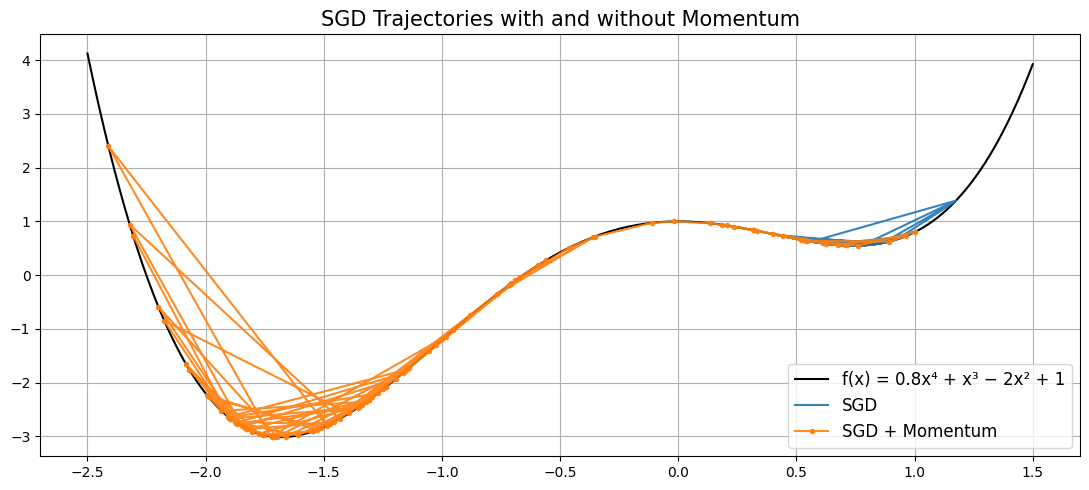

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# function with 2 minima
def func(x):
    return 0.8 * x**4 + x**3 - 2 * x**2 + 1

def grad(x):
    return 3.2 * x**3 + 3 * x**2 - 4 * x

def noisy_grad(x, noise_level=1.8):
    return grad(x) + noise_level * torch.randn_like(x)

def sgd(noisy_grad_fn, lr=0.1, steps=100, init=torch.tensor([1.0])):
    x = init.clone()
    traj = [x.clone()]
    for _ in range(steps):
        x -= lr * noisy_grad_fn(x)
        traj.append(x.clone())
    return traj

# SGD + Momentum
def sgd_momentum(init=torch.tensor([4.0]), lr=0.085, beta=0.9, steps=100):
    x = init.clone()
    v = torch.zeros_like(x)
    traj = [x.item()]
    for _ in range(steps):
        v = beta * v - lr * noisy_grad(x)
        x = x + v
        traj.append(x.item())
    return np.array(traj)

torch.manual_seed(42)
traj_sgd = sgd(noisy_grad, lr=0.085, steps=100)

torch.manual_seed(42)
start_x = torch.tensor([1.0])          # gần local min nông ở x ≈ -1.49
traj_momentum = sgd_momentum(init=start_x, lr=0.085, beta=0.9, steps=100)

traj_sgd = torch.stack(traj_sgd).squeeze()
#traj_momentum = torch.stack(traj_momentum).squeeze()

# Vẽ với range zoom đúng để thấy rõ bị kẹt
x_vals = np.linspace(-2.5, 1.5, 700)
y_vals = func(x_vals)

plt.figure(figsize=(11, 5))
plt.plot(x_vals, y_vals, linewidth=1.5, label='f(x) = 0.8x⁴ + x³ − 2x² + 1', color='black')
plt.plot(traj_sgd, func(traj_sgd),  markersize=2, linewidth=1.5, alpha=0.9,
         label='SGD')
plt.plot(traj_momentum, func(traj_momentum), marker='o', markersize=3, linewidth=1.5, alpha=0.9,
         label='SGD + Momentum')

plt.title('SGD Trajectories with and without Momentum',
          fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

As shown in the graph, the blue path (without Momentum) gets stuck at a local minimum, failing to reach the global minimum. In contrast, the orange path (with Momentum) escapes the local minimum and continues descending toward the global minimum, around $x \approx -1.7$

### 2. What happens when we use minibatch stochastic gradient descent with momentum?

- **Stochastic Gradient Descent (SGD)**: updates parameters using one sample, so the gradient is very noisy.
- **Mini-batch SGD**: uses a small batch (e.g., 16 or 32 samples), reducing noise while keeping updates fast.
- **Momentum**: accumulates past gradients to smooth the trajectory and speed up convergence.

Each step uses the **average gradient over a mini-batch**, and Momentum accumulates these batch-gradients over time.

This produces:

- Faster convergence than plain mini-batch SGD,
- Lower variance in updates,
- A smoother path through the optimization landscape,

More stable behavior in regions with high curvature or noise.
Let $\nabla_\mathbf{x} f(\mathbf{x}_t)$ be the gradient of a mini-batch:
<p align="center">$v_{t+1} = \beta v_t - \frac{1}{|B|} \sum_{i \in B} \nabla_\mathbf{x} f(\mathbf{x}_t) \\
\mathbf{x}_{t+1} = \mathbf{x}_t + \eta v_{t+1}
$</p>

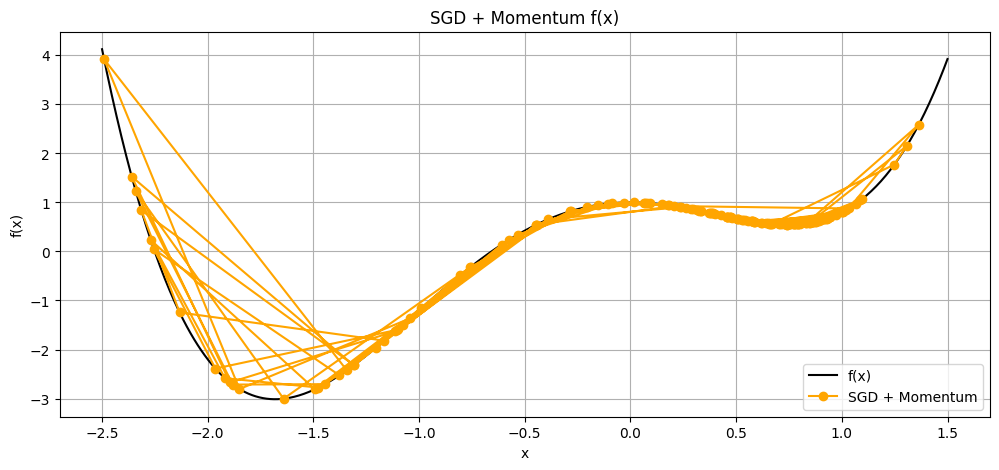

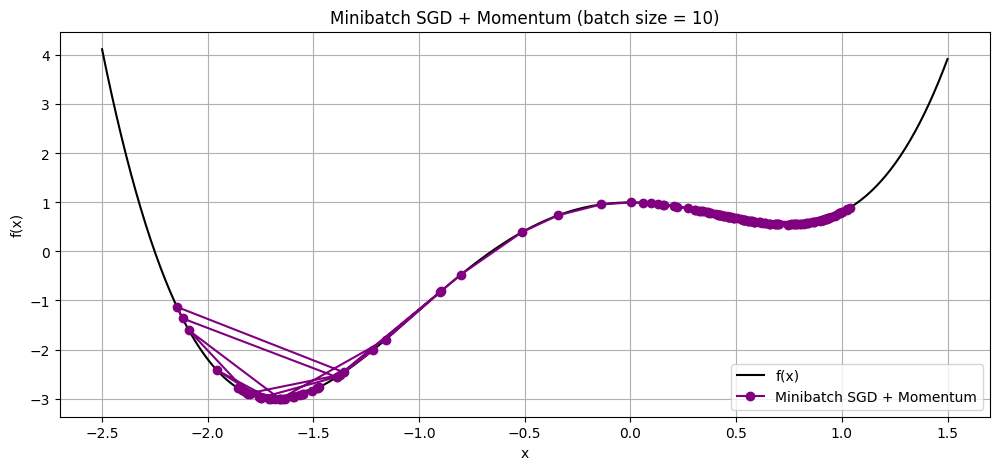

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# function with 2 minima
def func(x):
    return 0.8 * x**4 + x**3 - 2 * x**2 + 1

def grad(x):
    return 3.2 * x**3 + 3 * x**2 - 4 * x

def noisy_grad(x, noise_level=2.0):
    return grad(x) + noise_level * torch.randn_like(x)

# SGD + Momentum
def sgd_momentum(init=torch.tensor([4.0]), lr=0.085, beta=0.9, steps=100):
    x = init.clone()
    v = torch.zeros_like(x)
    traj = [x.item()]
    for _ in range(steps):
        v = beta * v - lr * noisy_grad(x)
        x = x + v
        traj.append(x.item())
    return np.array(traj)

# SGD + Momentum
def minibatch_sgd_momentum(init=torch.tensor([1.0]), lr=0.085, beta=0.9, steps=100,batch_size=10):
    x = init.clone()
    v = torch.zeros_like(x)
    traj = [x.item()]
    for _ in range(steps):
        grad = [noisy_grad(x) for _ in range(batch_size)]
        #mean batch
        avg_grad = torch.stack(grad).mean(dim=0)
        v = beta * v - lr * avg_grad
        x += v
        traj.append(x.item())

    return np.array(traj)

start_x = torch.tensor([1.0])
torch.manual_seed(42)
traj_momentum = sgd_momentum(init=start_x, lr=0.085, beta=0.9, steps=150)
torch.manual_seed(42)
traj_mb_momentum = minibatch_sgd_momentum(init=start_x, lr=0.085, beta=0.9,
                                          steps=150, batch_size=10)

x_vals = np.linspace(-2.5, 1.5, 700)
y_vals = func(x_vals)
# Plot SGD + Momentum
plt.figure(figsize=(12, 5))
plt.plot(x_vals, y_vals, label='f(x)', color='black')
plt.plot(traj_momentum, func(traj_momentum), 'orange', marker='o', label='SGD + Momentum')
plt.legend()
plt.title("SGD + Momentum f(x)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

# Plot Minibatch SGD + Momentum
plt.figure(figsize=(12, 5))
plt.plot(x_vals, y_vals, label='f(x)', color='black')
plt.plot(traj_mb_momentum, func(traj_mb_momentum), 'purple', marker='o', label='Minibatch SGD + Momentum')
plt.legend()
plt.title("Minibatch SGD + Momentum (batch size = 10)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

**SGD + Momentum:**
Even with momentum, the trajectory remains noticeably noisy because each update is based on a single sample. Momentum reduces some oscillation but cannot fully smooth the high-variance gradient.

**Minibatch SGD + Momentum:**
The trajectory becomes much smoother and more stable. Averaging gradients over a batch reduces noise, and momentum further accelerates convergence and stabilizes the update direction, leading to faster and more consistent progress toward the minimum

# 7. Summary

* Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.

* It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.

* Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.

* The effective number of gradients is given by $\frac{1}{1 - \beta}$ due to exponentiated downweighting of past data.

* In the case of convex quadratic problems this can be analyzed explicitly in detail.

* Implementation is quite straightforward but it requires us to store an additional state vector (velocity v).

# References

Bengio, Y., Goodfellow, I., & Courville, A. (2016). *Optimization*. In *Deep learning* (Chapter 8). MIT Press. https://www.deeplearningbook.org/contents/optimization.html

Dive into Deep Learning. *Momentum*. https://d2l.ai/chapter_optimization/momentum.html

Goh, G. (2017). Why momentum really works. *Distill*. https://doi.org/10.23915/distill.00006

Polyak, B. T. (1964). Some methods of speeding up the convergence of iteration methods. *USSR Computational Mathematics and Mathematical Physics, 4*(5), 1-17. https://papers.baulab.info/papers/also/Polyak-1964.pdf

Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013). On the importance of initialization and momentum in deep learning. *Proceedings of the 30th International Conference on Machine Learning (ICML)*, 28(3), 1139-1147. https://proceedings.mlr.press/v28/sutskever13.pdf

